# ECG Classification

Verify usage of GPU. If Num GPUs Available is 0, consider enabling at least one. Otherwise, the models take too long to fit. 

To avoid an error when loading *torch\lib\cublas64_11.dll*, we have to import torch before tensorflow.

In [3]:
# import torch
# print("Num GPUs Available: ", torch.cuda.device_count())

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Import modules.

In [5]:
# Data manipulation
import numpy as np
import pandas as pd

# Python waveform-database (WFDB) package
import wfdb

# Visualization
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool1D, MaxPool2D
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.layers import concatenate, add, Add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1 


# # PyTorch
# from torch import nn
# #!pip install torchsummary
# from torchsummary import summary

# Other
import os
import random
from loess.loess_1d import loess_1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.signal

# User defined
import scripts.plots_aux as pa
import scripts.load_data_aux as ld
import scripts.manipulate_data_aux as md
import scripts.utils_ecg as ue

# Downloaded scripts
from scripts.antonior92 import get_model

# Allow user defined modules to be dinamically updated
%load_ext autoreload
%autoreload 2

## Parameters and Preloaded Stuff

### Parameters

In [6]:
# Path to imagess folder
imgs_path = "imgs/"

# General random seed for replicability
random_state = 203129

# N of examples when plotting for each dx
n_sample = 5

# Fixed set of colors to identify the urgency level
urgency_colors = {1: '#EC0D0D', 2:'#EC7D0D', 3:'#E9EC0D', 4:'#0DEC84'}

# N of examples to plot the confusion matrix
n_ex = 500

# Thresholds to have more recall on specific classes
mi_threshold = 0.2
ms_threshold = 0.3
thresholds = {'PTB-XL':               
              {'MI' : 
                {'idx' : 0, 
                 'threshold' : mi_threshold},               
               'MI&STTC' : 
                {'idx' : 2,
                 'threshold' : ms_threshold}
              }
             }

# N of epochs for training models
epochs = 50

# Batch size for training models
batch_size = 64

# We are currently working only with PTB-XL
current_db = 'PTB-XL'
path = f'data/{current_db}/'
files = os.listdir(path)
hea_files = [file[:-4] for file in files if 'hea' in file]

# Whteher to compute spectograms or not as additional variables
compute_spectograms = False

### Load labels

In [7]:
# Load the Urgency and SNOMED CT Codes labels
labels = ld.load_labels('data/')

# This dictionary helps us pass info more easily to certain functions
requirements = {'path' : path, 'hea_files' : hea_files, 'imgs_path' : imgs_path,
                'current_db' : current_db, 'labels' : labels}

labels.head()

Diagnostic Description Abbreviation  Urgency  \
SNOMED CT Code                                                             
270492004                      1st degree av block         IAVB        4   
164889003                      atrial fibrillation           AF        4   
164890007                           atrial flutter          AFL        4   
426627000                              bradycardia        Brady        4   
713427006       complete right bundle branch block        CRBBB        3   

                CPSC  CPSC-Extra  StPetersburg  PTB  PTB-XL  Georgia  Total  \
SNOMED CT Code                                                                
270492004        722         106             0    0     797      769   2394   
164889003       1221         153             2   15    1514      570   3475   
164890007          0          54             0    1      73      186    314   
426627000          0         271            11    0       0        6    288   
713427006          0         113             0    0     542       28    683   

                                                            Notes  Kind  
SNOMED CT Code                                                           
270492004                                                     NaN  most  
164889003                                                     NaN  most  
164890007                                                     NaN  most  
426627000                                                     NaN  most  
713427006       We score 713427006 and 59118001 as the same di...  most

## Get all data

Retrieve the signal and the metadata for each file. This takes a like 2-3 minutes for the PTB-XL db.

# ----------------------------------------------------------------------------------------------------------

In [5]:
with open(path + hea_files[0] + '.hea', 'r') as f:
    lines = f.readlines()

In [6]:
import mat73

In [7]:
from scipy.io import loadmat

In [8]:
a = loadmat(path + hea_files[0] + '.mat', mat_dtype=np.float16)

In [9]:
b = wfdb.rdsamp(path + hea_files[0])

In [10]:
a['val'] / 200

array([[-0.575, -0.575, -0.575, ...,  1.05 ,  1.05 ,  1.05 ],
       [-0.25 , -0.25 , -0.25 , ...,  1.025,  1.025,  1.025],
       [ 0.325,  0.325,  0.325, ..., -0.025, -0.025, -0.025],
       ...,
       [-0.175, -0.175, -0.175, ...,  0.925,  0.925,  0.925],
       [-0.175, -0.175, -0.175, ...,  0.85 ,  0.85 ,  0.85 ],
       [-0.375, -0.375, -0.375, ...,  0.9  ,  0.9  ,  0.9  ]])

In [11]:
b[0]

array([[-0.575, -0.25 ,  0.325, ..., -0.175, -0.175, -0.375],
       [-0.575, -0.25 ,  0.325, ..., -0.175, -0.175, -0.375],
       [-0.575, -0.25 ,  0.325, ..., -0.175, -0.175, -0.375],
       ...,
       [ 1.05 ,  1.025, -0.025, ...,  0.925,  0.85 ,  0.9  ],
       [ 1.05 ,  1.025, -0.025, ...,  0.925,  0.85 ,  0.9  ],
       [ 1.05 ,  1.025, -0.025, ...,  0.925,  0.85 ,  0.9  ]])

In [12]:
lines

['HR00001 12 500 5000 04-Jun-2020 15:11:55\n',
 'HR00001.mat 16+24 200/mV 16 0 -115 13047 0 I\n',
 'HR00001.mat 16+24 200/mV 16 0 -50 11561 0 II\n',
 'HR00001.mat 16+24 200/mV 16 0 65 -1486 0 III\n',
 'HR00001.mat 16+24 200/mV 16 0 82 -12346 0 aVR\n',
 'HR00001.mat 16+24 200/mV 16 0 -90 7539 0 aVL\n',
 'HR00001.mat 16+24 200/mV 16 0 7 5145 0 aVF\n',
 'HR00001.mat 16+24 200/mV 16 0 -65 -5719 0 V1\n',
 'HR00001.mat 16+24 200/mV 16 0 -40 -21509 0 V2\n',
 'HR00001.mat 16+24 200/mV 16 0 -5 -1304 0 V3\n',
 'HR00001.mat 16+24 200/mV 16 0 -35 -15227 0 V4\n',
 'HR00001.mat 16+24 200/mV 16 0 -35 4821 0 V5\n',
 'HR00001.mat 16+24 200/mV 16 0 -75 12159 0 V6\n',
 '#Age: 56\n',
 '#Sex: Female\n',
 '#Dx: 251146004,426783006\n',
 '#Rx: Unknown\n',
 '#Hx: Unknown\n',
 '#Sx: Unknown\n']

In [13]:
all_files = []

# ----------------------------------------------------------------------------------------------------------

# Note: It would be best to have a process do the loading and the initial data preprocessing in one go, since doing both separated is slower I think.

In [8]:
# Initialize empty lists
X = []
Y = []

# Given the wfdb.rdsamp tuple, pass its values to X and Y, respectively
for file in hea_files:
    f = wfdb.rdsamp(path+file)
    X.append(f[0])
    Y.append(f[1])

Preprocess these to make them more easily usable. This takes like 4 minutes for the PTB-XL db.

In [9]:
X, Y = md.initial_data_preproc(X, Y)

Get some insight of what we just retrieved.

In [10]:
print(X.shape)
print(Y.shape)

(21837, 5000, 12)
(21837, 11)


In [11]:
print("An example of signals in raw format:\n", X[0])
print("\nMinimum value of signals:", X.min())
print("\nMaximum value of signals:", X.max())
print("\nQuantile 0.1% of signals:", np.quantile(X, 0.001))
print("\nQuantile 99.9% of signals:", np.quantile(X, 0.999))

An example of signals in raw format:
 [[-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 [-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 [-0.575 -0.25   0.325 ... -0.175 -0.175 -0.375]
 ...
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]
 [ 1.05   1.025 -0.025 ...  0.925  0.85   0.9  ]]

Minimum value of signals: -163.5

Maximum value of signals: 163.6

Quantile 0.1% of signals: -9.3125

Quantile 99.9% of signals: 8.6484375


In [12]:
Y.head()

age     sex                   dx       rx       hx       sx   fs sig_len  \
0  56  Female  251146004,426783006  Unknown  Unknown  Unknown  500    5000   
1  19    Male  426177001,426783006  Unknown  Unknown  Unknown  500    5000   
2  37  Female            426783006  Unknown  Unknown  Unknown  500    5000   
3  24    Male            426783006  Unknown  Unknown  Unknown  500    5000   
4  19  Female            426783006  Unknown  Unknown  Unknown  500    5000   

  n_sig                                             units  \
0    12  [mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]   
1    12  [mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]   
2    12  [mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]   
3    12  [mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]   
4    12  [mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV, mV]   

                                            sig_name  
0  [I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...  
1  [I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...  
2  [I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...  
3  [I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...  
4  [I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5...

We can see that only age, sex and dx change amongst the columns of Y, so we can omit them. However, this is the case for the PTB-XL db. It might be the case that other dbs have different values for these, so we will keep that in mind moving along the way.

#### Notes:

#### When we use more DBs alongside PTB-XL, we might find different values for these variables, in particular fs (frequency sample) and sig_len (signal length). When that moment comes, we should find a way to homologate them. 

#### Take into consideration that for some reason we are not being able to retrieve the mV unit. We know that all of PTB-XL are in 200. At least that's what we have seen from most opened .hea files, but there is no guarantee yet that they are all the same, nor that it is actually true. We say the latter since there is quite an amplitude difference in some signals, which could mostly be due to errors in measuerement, but it could also suggest that some signals were not actually recorded in 200 mV.

In [13]:
print("# of unique values of Rx:", Y['rx'].nunique())
print("# of unique values of Hx:", Y['hx'].nunique())
print("# of unique values of Sx:", Y['sx'].nunique())
print("# of unique values of fs:", Y['fs'].nunique())
print("# of unique values of sig_len:", Y['sig_len'].nunique())
print("# of unique values of n_sig:", Y['n_sig'].nunique())
print("# of unique values of units:", Y['units'].astype(str).nunique())
print("# of unique values of sig_name:", Y['sig_name'].astype(str).nunique())

# of unique values of Rx: 1
# of unique values of Hx: 1
# of unique values of Sx: 1
# of unique values of fs: 1
# of unique values of sig_len: 1
# of unique values of n_sig: 1
# of unique values of units: 1
# of unique values of sig_name: 1


### Labelling for each Diagnosis

We read it now to avoid possible future type mismatches

#### Note : Change 'Y.csv' so that it depends on the DB (or DBs) currently at use.

In [14]:
Y_df = pd.read_csv(path + 'Y.csv', index_col=0)
Y_df.columns = list(Y_df.columns[:11]) + list(Y_df.columns[11:].astype(np.int64))

#### Note: We are setting NaN values in age as 0. This is not necessarily correct, but it is a way to move forward. It's important to keep this in mind since we might later on chose something else, like setting an overall mean or a grouped by dx mean.

In [15]:
Y_df['age'] = Y_df['age'].fillna(0)
Y_df['age'] = Y_df['age'].apply(lambda x: int(x))

### Adding urgency to Y + EDA on DX

There are certain approaches we can take to classify the diagnoses:

    1. Have a multi-binary classification model that checks whether there is precense of the dx.
    2. Have a multi-class classification model that checks the urgency of opoeration for the patient.
    
Note how in a way the former one includes the latter, since having a strong indication of a dx that belongs 
to a certain urgency level would implicitly determine it.

In the latter one, we still have to determine how the combination of urgencies in each patient can change the overall
urgency. For example, suppose a patient has 3 dx with urgency level 2, and 3 with urgency level 3. Would this patient
be classified as an urgency level 2 one because the maximum urgency level is 2, or should it be ascended to 1 since it has multiple dx.

For the moment, we will assume the maximum per dx urgency level as the overall patient's one.

In [16]:
# Get OHE on the urgency of the diagnosis
Y_urgencies = np.array(pd.get_dummies(labels['Urgency']))

# Multiply by the dx in each row to get the total amount of dx per urgency
Y_urgencies = np.array(Y_df.iloc[:, 11:]) @ Y_urgencies

print(Y_urgencies.shape)
Y_urgencies

(21837, 4)


array([[0, 0, 0, 2],
       [0, 0, 0, 2],
       [0, 0, 0, 1],
       ...,
       [0, 1, 0, 1],
       [0, 0, 0, 2],
       [0, 0, 0, 1]], dtype=int64)

As mentioned, the patient's urgency level will be the highest priority urgency level per dx. Thus,
we multiply each of the previous matrix columns (urgencies) by wieghts, so that the maximum per row reflects the maximum urgency.

In [17]:
Y_urgencies_max = Y_urgencies.copy()

Y_urgencies_max[:, 0] = Y_urgencies_max[:, 0] * 1000000
Y_urgencies_max[:, 1] = Y_urgencies_max[:, 1] * 10000
Y_urgencies_max[:, 3] = Y_urgencies_max[:, 3] * 100

Y_urgencies_max = Y_urgencies_max.argmax(1) + 1

Y_urgencies_max

array([4, 4, 4, ..., 2, 4, 4], dtype=int64)

# Transform signals

We apply a transformation to normalize and correct the signals. To correct them, we use either our own methodology or one that a top ranking team in the Physionet Challenge did. For normalization, we try certain things ranging from having each signal be in [-1,1], standarizing through normal distribution assumption, etc., or doing a methodology from the top ranking teams.

#### Note that once we apply a transformation, all the signals are stored in the same array. We do this at the moment since having 2 

In [16]:
filter_bandwidth = [3, 45]

# correction = 'FIR Bandpass'
# standarization = '[-1,1]'
correction = None
standarization = None

apply_transformation = (correction is not None) or (standarization is not None)

In [17]:
n_X = X.shape[1]
n_channels = X.shape[2]

if apply_transformation:

    for i in range(n_X):
        for j in range(n_channels):

            x = X[i, :, j]        

            if correction == 'FIR Bandpass':
                x = md.apply_filter(x, filter_bandwidth)

            if standarization == '[-1,1]':
                x = 2 * ((x - x.min()) / (x.max() - x.min()) - 1/2)

            X[i, :, j] = x

# Spectogram 

#### Note: The fs should depend on the register. We use 500 now since all of PTB-XL are in 500.

In [80]:
if compute_spectograms:

    log_amplitudes = np.zeros(shape=(X.shape[0], 49, 16))

    for i in range(n_X):

            x = X[i, :, 1] # We use lead II i.e. index 1

            _, _, amplitude = scipy.signal.spectrogram(x, fs=500, nperseg=200, noverlap=100)

            amplitude = abs(amplitude)
            mask = amplitude > 0
            amplitude[mask] = np.log(amplitude[mask])

            log_amplitude = amplitude[(frequency > filter_bandwidth[0]) & (frequency < filter_bandwidth[1]), :]

            log_amplitudes[i, :, :] = log_amplitude.T

# ----------------------------------------------------------------------------------------------------------

# =============================================================

##  Urgency Level

# =============================================================

# ----------------------------------------------------------------------------------------------------------

### Train, Validation & Test

We first reduce the length of the signals since it would be too computationally costly otherwise atm.

In [23]:
# Notice that this way to cut currently works only for PTB-XL, since all records are the of
# the same duration and frequency sampling

cut = 0.3
X_cut = X[:, :int(cut * X.shape[1]), :]

#### Note: For this excercise, we will predict urgency levels (1,2,3,4) in a multi-binary way. That is, for example, if the patient has 2 urgency 1 dx, 1 urgency 2 dx and 3 urgency 4 dx, then y_i = [1, 1, 0, 1].

In [24]:
Y_urgs = Y_urgencies // Y_urgencies

<ipython-input-24-dc3bbaf43b20>:1: RuntimeWarning: divide by zero encountered in floor_divide
  Y_urgs = Y_urgencies // Y_urgencies


Define the proportions for each set.

In [30]:
val_size = 0.2
test_size = 0.2

Define the indices so that we can recover them later

In [31]:
indices = np.arange(len(X_cut))

Retrieve the train, validation and test sets for:

    x : The signals
    y : The labels
    idx : The indices of the original X and Y
    age_n_sex : The age and sex

#### Note: It is still not clear how to stratify since the labels are *not* mutually exclusive. For the moment we don't do it, but this should be later revised

In [32]:
# Train and test
train_set_x, test_set_x = train_test_split(X_cut, test_size=test_size, random_state=random_state)
train_set_y, test_set_y = train_test_split(Y_urgs, test_size=test_size, random_state=random_state)
train_set_idx, test_set_idx = train_test_split(indices, test_size=test_size, random_state=random_state)
# train_set_la, test_set_la = train_test_split(log_amplitudes, test_size=test_size, random_state=random_state)

# Train and val
train_set_x, val_set_x = train_test_split(train_set_x, test_size=val_size, random_state=random_state)
train_set_y, val_set_y = train_test_split(train_set_y, test_size=val_size, random_state=random_state)
train_set_idx, val_set_idx = train_test_split(train_set_idx, test_size=val_size, random_state=random_state)
# train_set_la, val_set_la = train_test_split(train_set_la, test_size=val_size, random_state=random_state)

# Get the age and sex given the indices
train_set_age_n_sex, mean_age = md.age_and_sex_set(Y, train_set_idx)
val_set_age_n_sex = md.age_and_sex_set(Y, val_set_idx, mean_age)
test_set_age_n_sex = md.age_and_sex_set(Y, test_set_idx, mean_age)

n_total_train = train_set_x.shape[0]
batches = n_total_train//batch_size

# train_set_y = np.array(train_set_y)
# val_set_y = np.array(val_set_y)
# test_set_y = np.array(test_set_y)

Verify if the total amount of values for each set is adequate

In [34]:
print(train_set_y.shape)
print(val_set_y.shape)
print(test_set_y.shape)

(13975, 4)
(3494, 4)
(4368, 4)


Verify the age and sex were correctly processed. 

### Note: At the moment, we are only using PTB-XL. When we use the other datasets, there is no guarantee that the preprocessing for age and sex will be the same.

In [35]:
Y.iloc[train_set_idx][['age', 'sex']].head()

age     sex
5000   69    Male
16835  67  Female
12356  49  Female
3450   24    Male
10222  63    Male

In [36]:
train_set_age_n_sex[:5]

array([[69,  1],
       [67,  0],
       [49,  0],
       [24,  1],
       [63,  1]], dtype=int64)

We verify that we have a stratified distribution of labels inthe 3 sets.

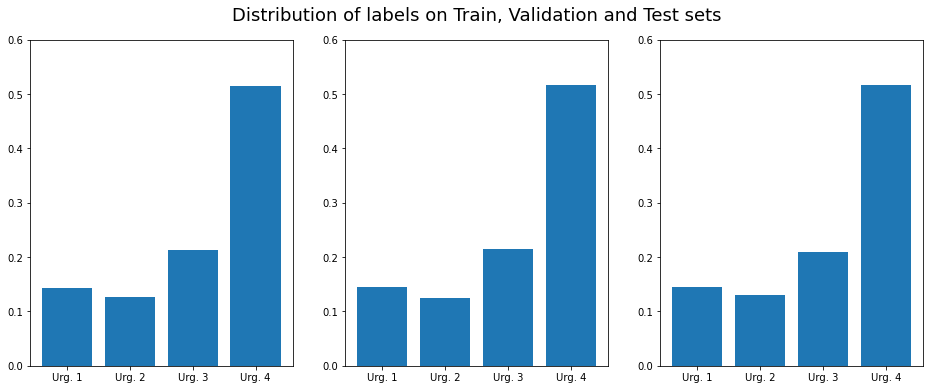

In [39]:
fig, axs = plt.subplots(1,3, figsize = (16,6))
axs[0].bar(['Urg. 1', 'Urg. 2', 'Urg. 3', 'Urg. 4'], train_set_y.sum(0) /  train_set_y.sum(), )
axs[1].bar(['Urg. 1', 'Urg. 2', 'Urg. 3', 'Urg. 4'], val_set_y.sum(0) /  val_set_y.sum())
axs[2].bar(['Urg. 1', 'Urg. 2', 'Urg. 3', 'Urg. 4'], test_set_y.sum(0) /  test_set_y.sum())
[ax.set_ylim(0,0.6) for ax in axs]

axs[1].set_title('Distribution of labels on Train, Validation and Test sets', y = 1.04, fontsize=18);

# =============================================================

### CNN Implementation

# =============================================================

# =============================================================

#### Multibinary - Simplest model

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [40]:
model_id = 'Urgency/own/multibinary_1.h5'

Parameters

In [41]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [43]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(64, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Conv1D(128, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Conv1D(256, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Flatten(),
            Dense(128, activation='relu'),
            Dense(4, activation='sigmoid')
])

In [38]:
CNN = Sequential([
    InputLayer(input_shape=(img_h, img_w)),
    
    Conv1D(64, 3, activation='relu', strides=1, padding="same"),
    MaxPool1D(),

    Conv1D(128, 3, activation='relu', strides=1, padding="same"),
    MaxPool1D(),

    Conv1D(256, 3, activation='relu', strides=1, padding="same"),
    MaxPool1D(),

    #Conv1D(64, 3, activation='relu'),
    #MaxPool2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='sigmoid')
])

CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1500, 64)          2368      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 750, 64)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 750, 128)          24704     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 375, 128)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 375, 256)          98560     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 187, 256)        

Summary.

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1500, 64)          2368      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 750, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 750, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 375, 256)          98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 187, 256)         0

In [45]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 17s 30ms/step - loss: 0.4255 - accuracy: 0.4137 - val_loss: 0.3784 - val_accuracy: 0.4153
Epoch 2/50
218/218 [==============================] - 7s 34ms/step - loss: 0.3494 - accuracy: 0.4145 - val_loss: 0.3417 - val_accuracy: 0.4153
Epoch 3/50
218/218 [==============================] - 8s 35ms/step - loss: 0.3139 - accuracy: 0.4174 - val_loss: 0.3469 - val_accuracy: 0.4164
Epoch 4/50
218/218 [==============================] - 7s 34ms/step - loss: 0.2747 - accuracy: 0.4223 - val_loss: 0.3636 - val_accuracy: 0.4262
Epoch 5/50
218/218 [==============================] - 8s 35ms/step - loss: 0.2253 - accuracy: 0.4441 - val_loss: 0.4258 - val_accuracy: 0.4325
Epoch 6/50
218/218 [==============================] - 7s 34ms/step - loss: 0.1626 - accuracy: 0.4635 - val_loss: 0.5002 - val_accuracy: 0.4439
Epoch 7/50
218/218 [==============================] - 7s 34ms/step - loss: 0.1021 - accuracy: 0.4715 - val_loss: 0.6403 - val_accuracy: 0.449

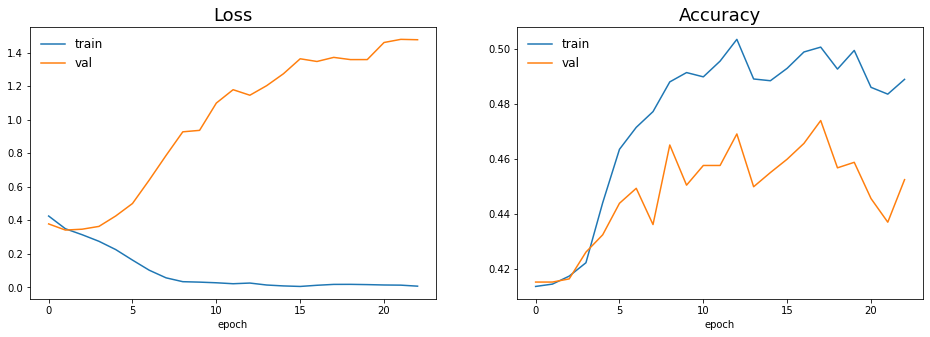

In [46]:
pa.plot_model_history(fitted_model)

**Without thresholds**

In [47]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

NameError: name 'strat_df' is not defined

**With thresholds**

In [ ]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# ----------------------------------------------------------------------------------------------------------

# =============================================================

## SNOMED CT Code

# =============================================================

# ----------------------------------------------------------------------------------------------------------

### Train, Validation & Test

We first reduce the length of the signals since it would be too computationally costly otherwise atm.

In [43]:
# Notice that this way to cut currently works only for PTB-XL, since all records are the of
# the same duration and frequency sampling

cut = 0.3
X_cut = X[:, :int(cut * X.shape[1]), :]

We define a set of target SNOMED CT Codes that we want to predict. In particular we choose those with Urgency Level 1, 2 or 3, as well as registers that the current db (PTB-XL) actually contains.

In [44]:
target_snomed = set(labels[labels['Urgency'] < 4].index)
target_snomed = target_snomed.intersection(set(labels[labels[current_db] > 0].index))

Define the proportions for each set.

In [45]:
val_size = 0.2
test_size = 0.2

Define the indices so that we can recover them later

In [90]:
indices = np.arange(len(X_cut))

Retrieve the train, validation and test sets for:

    x : The signals
    y : The labels
    idx : The indices of the original X and Y
    age_n_sex : The age and sex

#### Note: It is still not clear how to stratify since the labels are *not* mutually exclusive. For the moment we don't do it, but this should be later revised. There could be some ideas we can take from the submitted codes for each team in the Physionet Challenge. I believe some of them had already some recommended folds for each dataset.

In [92]:
# Train and test
train_set_x, test_set_x = train_test_split(X_cut, test_size=test_size, random_state=random_state)
train_set_y, test_set_y = train_test_split(Y_df[target_snomed], test_size=test_size, random_state=random_state)
train_set_idx, test_set_idx = train_test_split(indices, test_size=test_size, random_state=random_state)
# train_set_la, test_set_la = train_test_split(log_amplitudes, test_size=test_size, random_state=random_state)

# Train and val
train_set_x, val_set_x = train_test_split(train_set_x, test_size=val_size, random_state=random_state)
train_set_y, val_set_y = train_test_split(train_set_y, test_size=val_size, random_state=random_state)
train_set_idx, val_set_idx = train_test_split(train_set_idx, test_size=val_size, random_state=random_state)
# train_set_la, val_set_la = train_test_split(train_set_la, test_size=val_size, random_state=random_state)

# Get the age and sex given the indices
train_set_age_n_sex, mean_age = md.age_and_sex_set(Y, train_set_idx)
val_set_age_n_sex = md.age_and_sex_set(Y, val_set_idx, mean_age)
test_set_age_n_sex = md.age_and_sex_set(Y, test_set_idx, mean_age)

n_total_train = train_set_x.shape[0]
batches = n_total_train//batch_size

train_set_y = np.array(train_set_y)
val_set_y = np.array(val_set_y)
test_set_y = np.array(test_set_y)

Verify if the total amount of values for each set is adequate

In [65]:
print(train_set_y.shape)
print(val_set_y.shape)
print(test_set_y.shape)

(13975, 4)
(3494, 4)
(4368, 4)


Verify the age and sex were correctly processed. 

### Note: At the moment, we are only using PTB-XL. When we use the other datasets, there is no guarantee that the preprocessing for age and sex will be the same.

In [105]:
Y.iloc[train_set_idx][['age', 'sex']].head()

age     sex
5000   69    Male
16835  67  Female
12356  49  Female
3450   24    Male
10222  63    Male

In [106]:
train_set_age_n_sex[:5]

array([[69,  1],
       [67,  0],
       [49,  0],
       [24,  1],
       [63,  1]], dtype=int64)

We verify that we have a stratified distribution of labels inthe 3 sets.

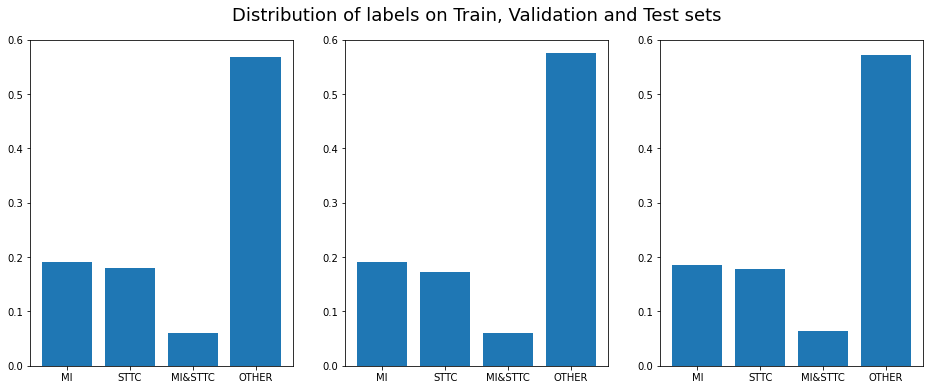

In [93]:
fig, axs = plt.subplots(1,3, figsize = (16,6))
axs[0].bar(strat_df.columns[:-1], train_set_y.sum(0) /  train_set_y.sum(), )
axs[1].bar(strat_df.columns[:-1], val_set_y.sum(0) /  val_set_y.sum())
axs[2].bar(strat_df.columns[:-1], test_set_y.sum(0) /  test_set_y.sum())
[ax.set_ylim(0,0.6) for ax in axs]

axs[1].set_title('Distribution of labels on Train, Validation and Test sets', y = 1.04, fontsize=18);

# =============================================================

### CNN Implementation

# =============================================================

#### Basic Initial Model

In [61]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]

optimizer = 'adam'

In [67]:
CNN = Sequential([
    InputLayer(input_shape=(img_h, img_w)),
    
    Conv1D(64, 3, activation='relu', strides=1, padding="same"),
    MaxPool1D(),

    Conv1D(128, 3, activation='relu', strides=1, padding="same"),
    MaxPool1D(),

    Conv1D(256, 3, activation='relu', strides=1, padding="same"),
    MaxPool1D(),

    #Conv1D(64, 3, activation='relu'),
    #MaxPool2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_set_y.shape[1], activation='sigmoid')
])

CNN.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 1500, 64)          2368      
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 750, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 750, 128)          24704     
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 375, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 375, 256)          98560     
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 187, 256)        

In [69]:
# Compile: Define training parameters
# CNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
CNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['categorical_accuracy'])

# Train model
epochs = 50
batches = n_total_train//batch_size

### Following line overflows memory
fitted_model = CNN.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                       epochs=epochs, validation_data=(val_set_x, val_set_y),                        
                       callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=5)])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

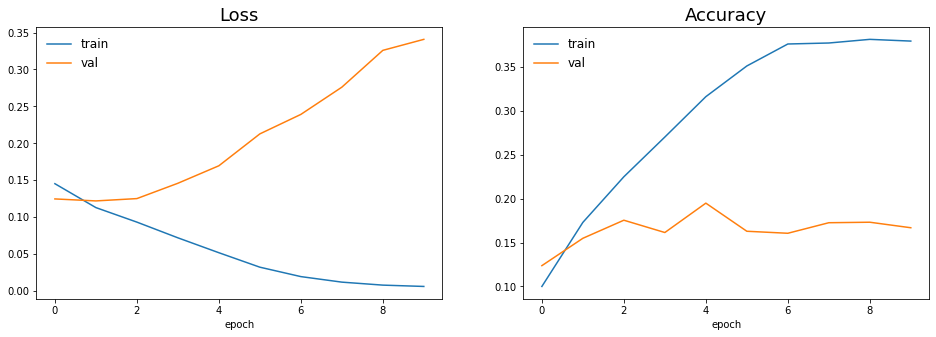

In [217]:
pa.plot_model_history(fitted_model)

#### Adding...

In [307]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256

optimizer = 'adam'

In [60]:
CNN = Sequential([
    InputLayer(input_shape=(img_h, img_w)),
    
    Conv1D(128, 14, activation='relu', strides=3, padding="same"),
    MaxPool1D(),

    Conv1D(256, 14, activation='relu', strides=3, padding="same"),
    MaxPool1D(),

    Conv1D(d_model, 10, activation='relu', strides=2, padding="same"),
    MaxPool1D(),

    #Conv1D(64, 3, activation='relu'),
    #MaxPool2D(),

    Flatten(),
    Dense(d_model, activation='relu'),
    Dense(len(target_snomed), activation='sigmoid')
])

CNN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 500, 128)          21632     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 250, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 84, 256)           459008    
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 42, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 21, 256)           655616    
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 10, 256)         

In [314]:
# Compile: Define training parameters
# CNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
CNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train model
epochs = 50
batches = n_total_train//batch_size

### Following line overflows memory
fitted_model = CNN.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                       epochs=epochs, validation_data=(val_set_x, val_set_y),
                       callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/50
218/218 [==============================] - 35s 157ms/step - loss: 0.1462 - accuracy: 0.0920 - val_loss: 0.1224 - val_accuracy: 0.1291
Epoch 2/50
218/218 [==============================] - 37s 168ms/step - loss: 0.1097 - accuracy: 0.1960 - val_loss: 0.1112 - val_accuracy: 0.1737
Epoch 3/50
218/218 [==============================] - 40s 181ms/step - loss: 0.0980 - accuracy: 0.2190 - val_loss: 0.1049 - val_accuracy: 0.1820
Epoch 4/50
218/218 [==============================] - 40s 184ms/step - loss: 0.0881 - accuracy: 0.2365 - val_loss: 0.1023 - val_accuracy: 0.1915
Epoch 5/50
218/218 [==============================] - 40s 182ms/step - loss: 0.0792 - accuracy: 0.2475 - val_loss: 0.1143 - val_accuracy: 0.1697
Epoch 6/50
218/218 [==============================] - 40s 183ms/step - loss: 0.0683 - accuracy: 0.2742 - val_loss: 0.1191 - val_accuracy: 0.1938
Epoch 7/50
218/218 [==============================] - 41s 188ms/step - loss: 0.0546 - accuracy: 0.3032 - val_loss: 0.1355 - val_ac

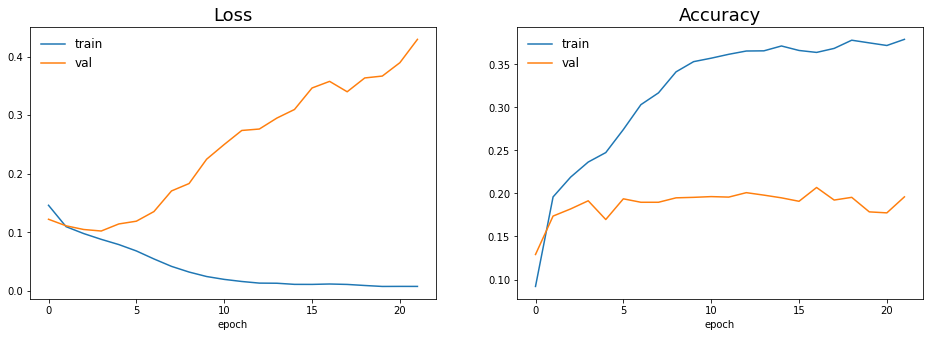

In [315]:
pa.plot_model_history(fitted_model)

# ----------------------------------------------------------------------------------------------------------

# =============================================================

## PTB-XL Superclasses

# =============================================================

# ----------------------------------------------------------------------------------------------------------

### Loading Superclasses

In [23]:
# import ast

# # load and convert annotation data
# Y_ptbxl = pd.read_csv('data/ptbxl_database.csv', index_col='ecg_id')
# Y_ptbxl.scp_codes = Y_ptbxl.scp_codes.apply(lambda x: ast.literal_eval(x))

# # Load scp_statements.csv for diagnostic aggregation
# agg_df = pd.read_csv('data/scp_statements.csv', index_col=0)
# agg_df = agg_df[agg_df.diagnostic == 1]

# def aggregate_diagnostic(y_dic):
#     tmp = []
#     for key in y_dic.keys():
#         if key in agg_df.index:
#             tmp.append(agg_df.loc[key].diagnostic_class)
#     return list(set(tmp))

# # Apply diagnostic superclass
# Y_ptbxl['diagnostic_superclass'] = Y_ptbxl.scp_codes.apply(aggregate_diagnostic)

# superclasses = set(agg_df.diagnostic_class)

This can take some time. For this reason we rather save it as a .csv file for later use.

In [24]:
# superclasses_df = pd.DataFrame(columns = superclasses)

# for i in range(len(Y_ptbxl.diagnostic_superclass)):
    
#     class_aux = pd.DataFrame(index = [0], columns = superclasses)
    
#     for sc in Y_ptbxl.diagnostic_superclass.iloc[i]:
#         class_aux.loc[0, sc] = 1
        
        
#     superclasses_df = pd.concat([superclasses_df, class_aux])
    
# superclasses_df = superclasses_df.fillna(0)

# superclasses_df.to_csv('data/PTB-XL/Y_superclasses.csv')

Read the previously calculated DF:

In [86]:
superclasses_df = pd.read_csv('data/PTB-XL/Y_superclasses.csv', index_col=0)

We are mostly interested in the MI and STTC classes. For this reason, we OHE so that we have mutually exclusive columns for:

    i. MI (no STTC)
    ii. STTC (no MI)
    iii MI & STTC
    iv. Other

In [87]:
# Copy and keep only the classes of interest
strat_df = superclasses_df.copy()
strat_df = strat_df.reset_index()
strat_df.index = strat_df.index + 1
strat_df = strat_df[['MI', 'STTC']]

# Intersection between MI & STTC
strat_df['MI&STTC'] = (strat_df['MI'] == 1) & (strat_df['STTC'] == 1)
strat_df['MI&STTC'] = strat_df['MI&STTC'].astype(int)

# Correct MI and STTC columns given an intersection
strat_df['MI'] = strat_df['MI'] - strat_df['MI&STTC']
strat_df['STTC'] = strat_df['STTC'] - strat_df['MI&STTC']

# Create the OTHER column as the complement
strat_df['OTHER'] = (strat_df['MI'] == 0) & (strat_df['STTC'] == 0) & (strat_df['MI&STTC'] == 0)
strat_df['OTHER'] = strat_df['OTHER'].astype(int)

# Add a label column 
strat_df['label'] = strat_df.idxmax(axis=1)
print(strat_df.shape)
strat_df.head()

(21837, 5)


MI  STTC  MI&STTC  OTHER  label
1   0     0        0      1  OTHER
2   0     0        0      1  OTHER
3   0     0        0      1  OTHER
4   0     0        0      1  OTHER
5   0     0        0      1  OTHER

### Train, Validation & Test

We first reduce the length of the signals since it would be too computationally costly otherwise atm.

In [88]:
# Notice that this way to cut currently works only for PTB-XL, since all records are the of
# the same duration and frequency sampling

cut = 0.3
X_cut = X[:, :int(cut * X.shape[1]), :]

Define the proportions for each set.

In [89]:
val_size = 0.2
test_size = 0.2

Define the indices so that we can recover them later

In [90]:
indices = np.arange(len(X_cut))

Retrieve the train, validation and test sets for:

    x : The signals
    y : The labels
    idx : The indices of the original X and Y
    age_n_sex : The age and sex

In [92]:
# Train and test
train_set_x, test_set_x = train_test_split(X_cut, test_size=test_size, random_state=random_state)
train_set_y, test_set_y = train_test_split(strat_df.drop(['label'], 1), test_size=test_size, random_state=random_state)
train_set_idx, test_set_idx = train_test_split(indices, test_size=test_size, random_state=random_state)
# train_set_la, test_set_la = train_test_split(log_amplitudes, test_size=test_size, random_state=random_state)

# Train and val
train_set_x, val_set_x = train_test_split(train_set_x, test_size=val_size, random_state=random_state)
train_set_y, val_set_y = train_test_split(train_set_y, test_size=val_size, random_state=random_state)
train_set_idx, val_set_idx = train_test_split(train_set_idx, test_size=val_size, random_state=random_state)
# train_set_la, val_set_la = train_test_split(train_set_la, test_size=val_size, random_state=random_state)

# Get the age and sex given the indices
train_set_age_n_sex, mean_age = md.age_and_sex_set(Y, train_set_idx)
val_set_age_n_sex = md.age_and_sex_set(Y, val_set_idx, mean_age)
test_set_age_n_sex = md.age_and_sex_set(Y, test_set_idx, mean_age)

n_total_train = train_set_x.shape[0]
batches = n_total_train//batch_size

train_set_y = np.array(train_set_y)
val_set_y = np.array(val_set_y)
test_set_y = np.array(test_set_y)

Verify if the total amount of values for each set is adequate

In [65]:
print(train_set_y.shape)
print(val_set_y.shape)
print(test_set_y.shape)

(13975, 4)
(3494, 4)
(4368, 4)


Verify the age and sex were correctly processed. 

### Note: At the moment, we are only using PTB-XL. When we use the other datasets, there is no guarantee that the preprocessing for age and sex will be the same.

In [105]:
Y.iloc[train_set_idx][['age', 'sex']].head()

age     sex
5000   69    Male
16835  67  Female
12356  49  Female
3450   24    Male
10222  63    Male

In [106]:
train_set_age_n_sex[:5]

array([[69,  1],
       [67,  0],
       [49,  0],
       [24,  1],
       [63,  1]], dtype=int64)

We verify that we have a stratified distribution of labels inthe 3 sets.

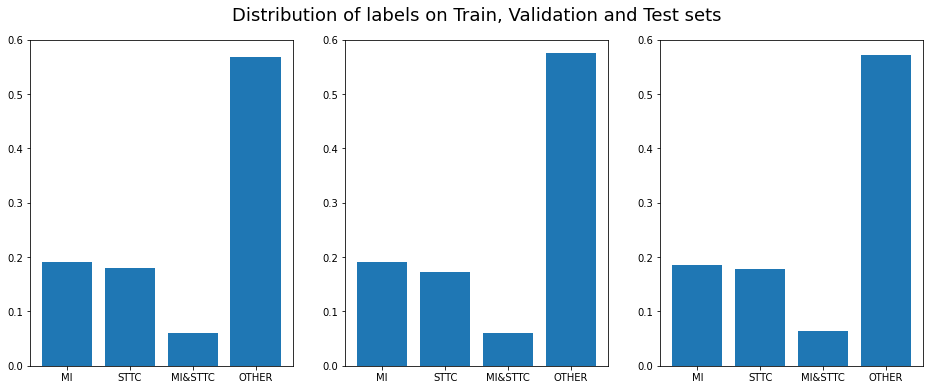

In [93]:
fig, axs = plt.subplots(1,3, figsize = (16,6))
axs[0].bar(strat_df.columns[:-1], train_set_y.sum(0) /  train_set_y.sum(), )
axs[1].bar(strat_df.columns[:-1], val_set_y.sum(0) /  val_set_y.sum())
axs[2].bar(strat_df.columns[:-1], test_set_y.sum(0) /  test_set_y.sum())
[ax.set_ylim(0,0.6) for ax in axs]

axs[1].set_title('Distribution of labels on Train, Validation and Test sets', y = 1.04, fontsize=18);

# =============================================================

### CNN Implementation

# =============================================================

#### Multibinary - Simplest model

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [109]:
model_id = 'PTB-XL_labels/fir_m1_p1/multibinary_1.h5'

Parameters

In [110]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [111]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(64, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Conv1D(128, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Conv1D(256, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Flatten(),
            Dense(128, activation='relu'),
            Dense(4, activation='sigmoid')
])

Summary.

In [112]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1500, 64)          2368      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 750, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 750, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 375, 256)          98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 187, 256)         0

In [113]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 15s 32ms/step - loss: 0.4231 - accuracy: 0.6071 - val_loss: 0.3993 - val_accuracy: 0.6362
Epoch 2/50
218/218 [==============================] - 7s 31ms/step - loss: 0.3541 - accuracy: 0.6814 - val_loss: 0.3583 - val_accuracy: 0.6800
Epoch 3/50
218/218 [==============================] - 7s 31ms/step - loss: 0.3170 - accuracy: 0.7229 - val_loss: 0.3482 - val_accuracy: 0.6923
Epoch 4/50
218/218 [==============================] - 7s 31ms/step - loss: 0.2809 - accuracy: 0.7568 - val_loss: 0.3955 - val_accuracy: 0.6697
Epoch 5/50
218/218 [==============================] - 7s 31ms/step - loss: 0.2372 - accuracy: 0.8010 - val_loss: 0.4369 - val_accuracy: 0.6815
Epoch 6/50
218/218 [==============================] - 7s 31ms/step - loss: 0.1800 - accuracy: 0.8528 - val_loss: 0.5070 - val_accuracy: 0.6620
Epoch 7/50
218/218 [==============================] - 7s 31ms/step - loss: 0.1365 - accuracy: 0.8948 - val_loss: 0.6447 - val_accuracy: 0.655

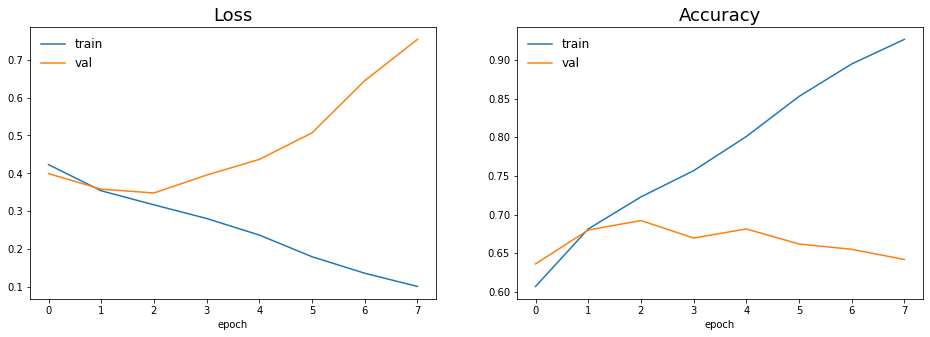

In [115]:
pa.plot_model_history(fitted_model)

**Without thresholds**

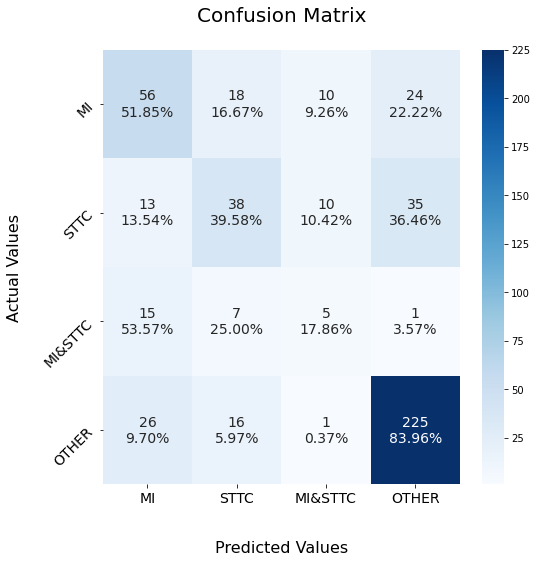

In [116]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

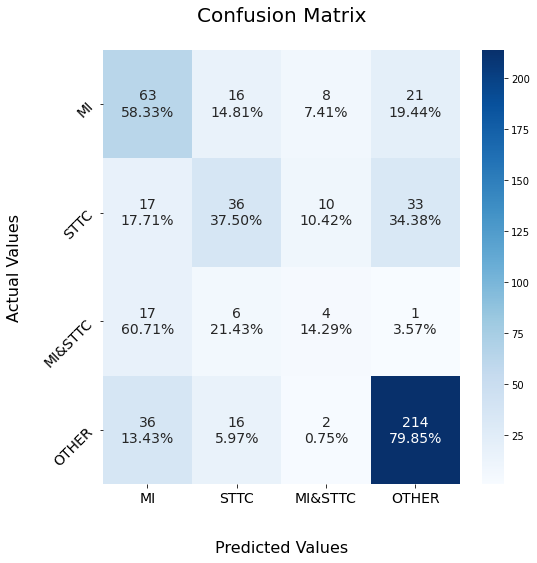

In [117]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [134]:
model_id = 'PTB-XL_labels/own/multibinary_2.h5'

Parameters

In [135]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [137]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same"),
            MaxPool1D(),

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
])

Summary.

In [138]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 500, 128)          21632     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 250, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 84, 256)           459008    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 42, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 21, 256)           655616    
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 10, 256)         

In [139]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 8s 35ms/step - loss: 0.3854 - accuracy: 0.6477 - val_loss: 0.3147 - val_accuracy: 0.7189
Epoch 2/50
218/218 [==============================] - 7s 33ms/step - loss: 0.3004 - accuracy: 0.7411 - val_loss: 0.2943 - val_accuracy: 0.7398
Epoch 3/50
218/218 [==============================] - 7s 34ms/step - loss: 0.2747 - accuracy: 0.7647 - val_loss: 0.3007 - val_accuracy: 0.7421
Epoch 4/50
218/218 [==============================] - 7s 33ms/step - loss: 0.2457 - accuracy: 0.7886 - val_loss: 0.3263 - val_accuracy: 0.7293
Epoch 5/50
218/218 [==============================] - 7s 33ms/step - loss: 0.2197 - accuracy: 0.8172 - val_loss: 0.3309 - val_accuracy: 0.7476
Epoch 6/50
218/218 [==============================] - 7s 33ms/step - loss: 0.1786 - accuracy: 0.8511 - val_loss: 0.3938 - val_accuracy: 0.7330
Epoch 7/50
218/218 [==============================] - 7s 32ms/step - loss: 0.1378 - accuracy: 0.8917 - val_loss: 0.4917 - val_accuracy: 0.7353

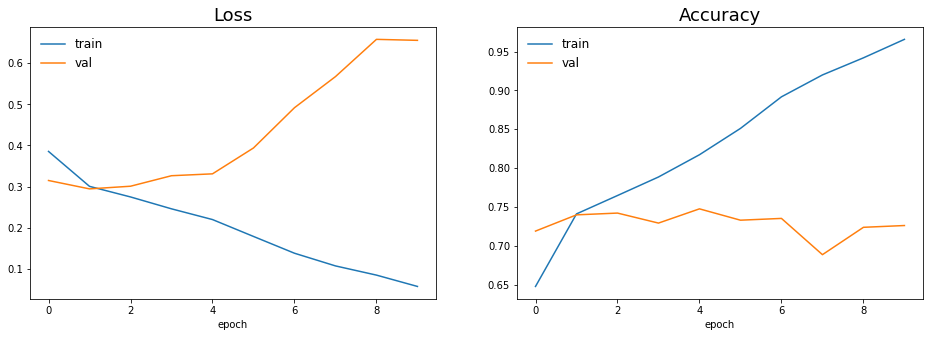

In [140]:
pa.plot_model_history(fitted_model)

**Without thresholds**

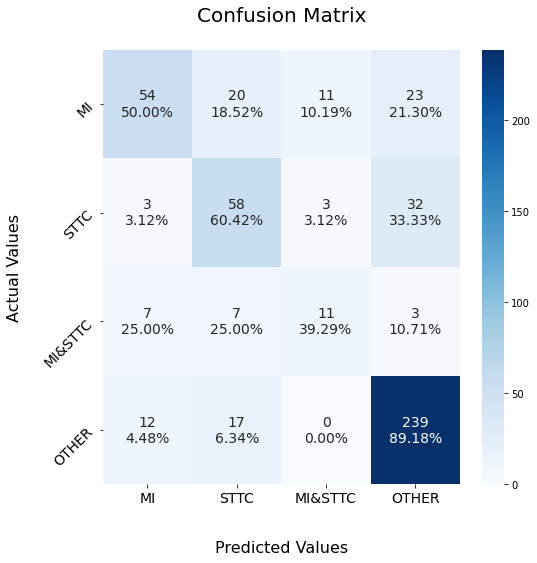

In [141]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

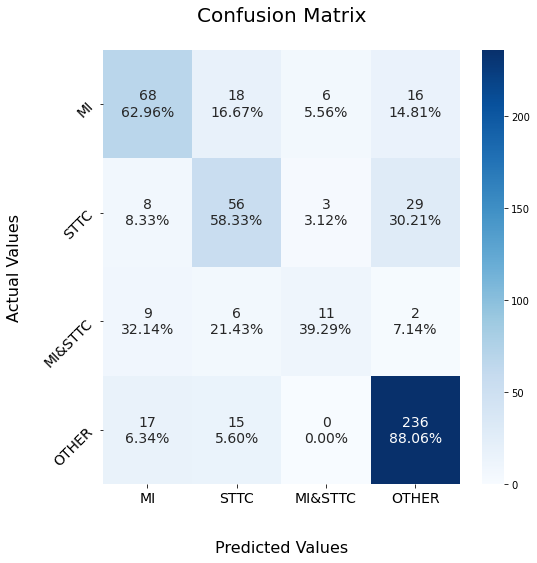

In [142]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes  + BatchNormalization + L1 Regularizer + Spectogram

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [97]:
model_id = 'PTB-XL_labels/fir_m1_p1/multibinary_bn_l1_dr_sp_1.h5'

Parameters

In [98]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
la_h = log_amplitudes.shape[1]
la_w = log_amplitudes.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [99]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    
    ### Convolutional Model
    conv_input = Input(shape=(img_h, img_w))

    x = Conv1D(128, 14, activation='relu', strides=3, padding="same")(conv_input)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(256, 14, activation='relu', strides=3, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006))(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Model(inputs = conv_input, outputs = x)
    
    
    ### Spectogram Model
    spec_input = Input(shape=(la_h, la_w))    

    s = Conv1D(128, 5, activation='relu', strides=3, padding="same")(spec_input)
    s = MaxPool1D()(s)
    s = Dropout(rate=0.3)(s)
    s = BatchNormalization()(s)

    s = Conv1D(256, 4, activation='relu', strides=3, padding="same")(s)
    s = MaxPool1D()(s)
    s = Dropout(rate=0.3)(s)
    s = BatchNormalization()(s)

    s = Conv1D(d_model, 3, activation='relu', strides=3, padding="same", activity_regularizer=L1(l1=0.006))(s)
    s = Dropout(rate=0.3)(s)
    s = BatchNormalization()(s)
    
    s = Flatten()(s)

    s = Model(inputs = spec_input, outputs = s)
    
    
    ### Combined Model
    combined = concatenate([x.output, s.output])
    z = Dense(d_model, activation='relu')(combined)
    z = Dense(4, activation='sigmoid')(z)

    model = Model(inputs=[x.input, s.input], outputs=z)

Summary.

In [100]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1500, 12)]   0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 500, 128)     21632       ['input_12[0][0]']               
                                                                                                  
 max_pooling1d_32 (MaxPooling1D  (None, 250, 128)    0           ['conv1d_36[0][0]']              
 )                                                                                                
                                                                                                  
 dropout_30 (Dropout)           (None, 250, 128)     0           ['max_pooling1d_32[0][0]']

 dense_7 (Dense)                (None, 4)            1028        ['dense_6[0][0]']                
                                                                                                  
Total params: 2,334,468
Trainable params: 2,331,396
Non-trainable params: 3,072
__________________________________________________________________________________________________


In [101]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit((train_set_x, train_set_la), train_set_y, steps_per_epoch=batches,
                               epochs=100, validation_data=((val_set_x, val_set_la), val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/100
218/218 [==============================] - 23s 41ms/step - loss: 0.8324 - accuracy: 0.5486 - val_loss: 0.4814 - val_accuracy: 0.5753
Epoch 2/100
218/218 [==============================] - 8s 37ms/step - loss: 0.4927 - accuracy: 0.5657 - val_loss: 0.4757 - val_accuracy: 0.5753
Epoch 3/100
218/218 [==============================] - 8s 38ms/step - loss: 0.4618 - accuracy: 0.5794 - val_loss: 0.4440 - val_accuracy: 0.5793
Epoch 4/100
218/218 [==============================] - 10s 45ms/step - loss: 0.4487 - accuracy: 0.5949 - val_loss: 0.4159 - val_accuracy: 0.6288
Epoch 5/100
218/218 [==============================] - 11s 50ms/step - loss: 0.4260 - accuracy: 0.6167 - val_loss: 0.4085 - val_accuracy: 0.6345
Epoch 6/100
218/218 [==============================] - 11s 51ms/step - loss: 0.4184 - accuracy: 0.6264 - val_loss: 0.3933 - val_accuracy: 0.6417
Epoch 7/100
218/218 [==============================] - 11s 51ms/step - loss: 0.4038 - accuracy: 0.6478 - val_loss: 0.3774 - val_accu

218/218 [==============================] - 25s 115ms/step - loss: 0.2785 - accuracy: 0.7800 - val_loss: 0.2994 - val_accuracy: 0.7570
Epoch 58/100
218/218 [==============================] - 35s 159ms/step - loss: 0.2754 - accuracy: 0.7785 - val_loss: 0.3110 - val_accuracy: 0.7447
Epoch 59/100
218/218 [==============================] - 39s 180ms/step - loss: 0.2769 - accuracy: 0.7793 - val_loss: 0.2993 - val_accuracy: 0.7536
Epoch 60/100
218/218 [==============================] - 38s 176ms/step - loss: 0.2740 - accuracy: 0.7831 - val_loss: 0.3016 - val_accuracy: 0.7438


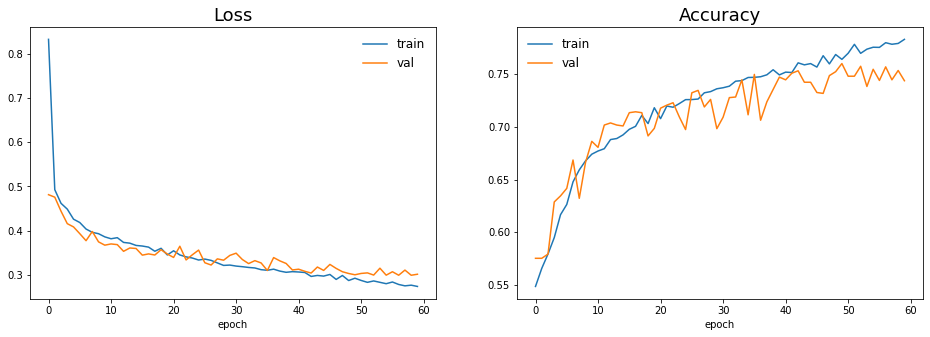

In [102]:
pa.plot_model_history(fitted_model)

**Without thresholds**

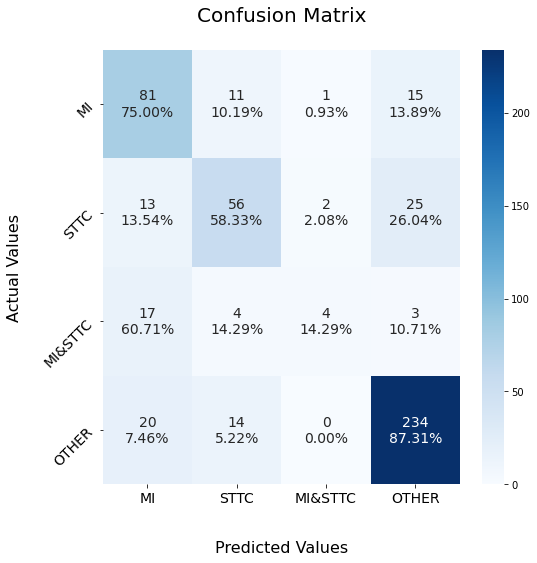

In [104]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_la), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

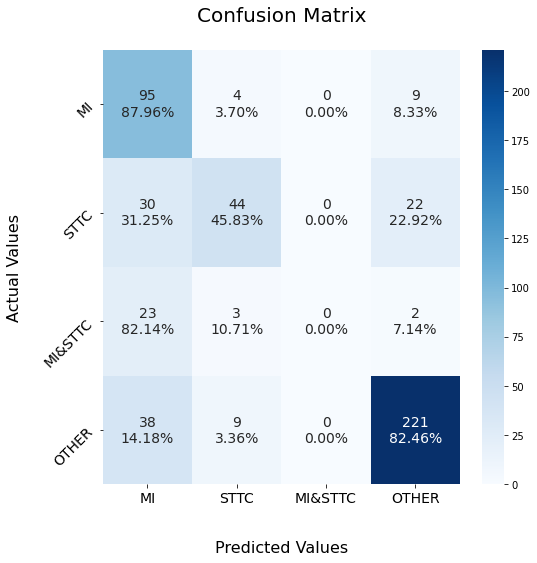

In [105]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_la), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [123]:
model_id = 'PTB-XL_labels/own/multibinary_bn_1.h5'

Parameters

In [124]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [125]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same", use_bias=False),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same", use_bias=False),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", use_bias=False),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", use_bias=False),
            BatchNormalization(),

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [126]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 500, 128)          21504     
                                                                 
 batch_normalization_18 (Bat  (None, 500, 128)         512       
 chNormalization)                                                
                                                                 
 conv1d_19 (Conv1D)          (None, 167, 256)          458752    
                                                                 
 batch_normalization_19 (Bat  (None, 167, 256)         1024      
 chNormalization)                                                
                                                                 
 conv1d_20 (Conv1D)          (None, 84, 256)           655360    
                                                                 
 batch_normalization_20 (Bat  (None, 84, 256)         

In [127]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 18s 74ms/step - loss: 0.5032 - accuracy: 0.6195 - val_loss: 0.3651 - val_accuracy: 0.6809
Epoch 2/50
218/218 [==============================] - 15s 70ms/step - loss: 0.3230 - accuracy: 0.7143 - val_loss: 0.3829 - val_accuracy: 0.6986
Epoch 3/50
218/218 [==============================] - 20s 90ms/step - loss: 0.2876 - accuracy: 0.7475 - val_loss: 0.3250 - val_accuracy: 0.7195
Epoch 4/50
218/218 [==============================] - 34s 154ms/step - loss: 0.2526 - accuracy: 0.7838 - val_loss: 0.3263 - val_accuracy: 0.7267
Epoch 5/50
218/218 [==============================] - 28s 130ms/step - loss: 0.2188 - accuracy: 0.8179 - val_loss: 0.3460 - val_accuracy: 0.7212
Epoch 6/50
218/218 [==============================] - 28s 127ms/step - loss: 0.1708 - accuracy: 0.8709 - val_loss: 0.3783 - val_accuracy: 0.7258
Epoch 7/50
218/218 [==============================] - 28s 130ms/step - loss: 0.1275 - accuracy: 0.9088 - val_loss: 0.4772 - val_accur

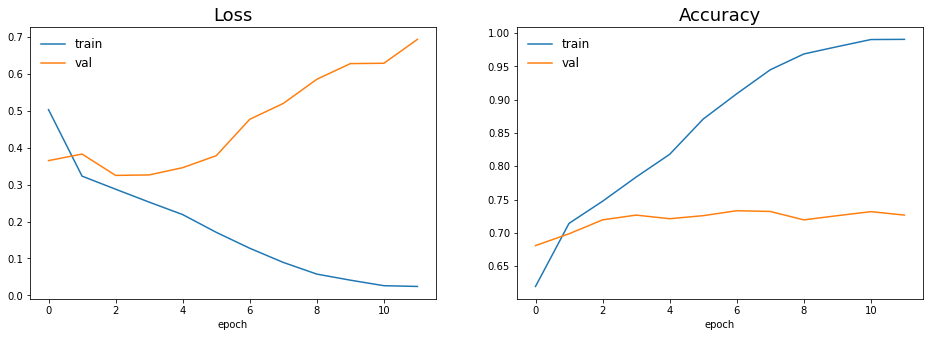

In [128]:
pa.plot_model_history(fitted_model)

**Without thresholds**

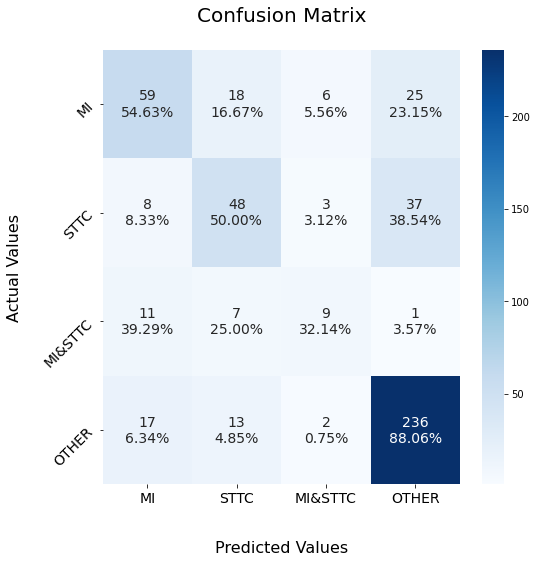

In [129]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

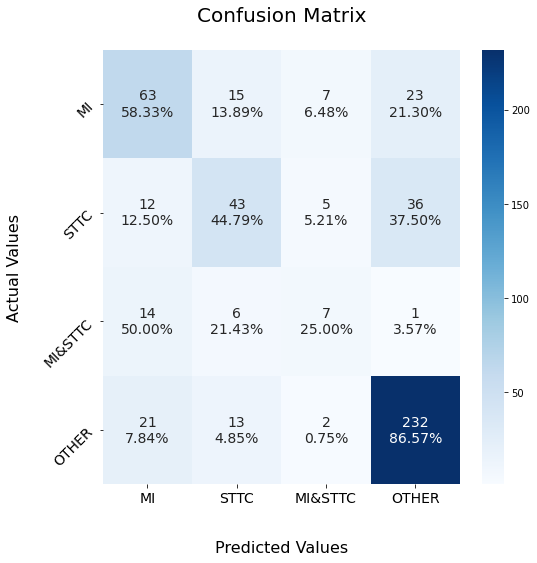

In [130]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [44]:
model_id = 'PTB-XL_labels/own/multibinary_bn_l1_2.h5'

Parameters

In [45]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [46]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.01)),
            MaxPool1D(),
            BatchNormalization(),            

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 500, 128)          21632     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 250, 128)         512       
 ormalization)                                                   
                                                                 
 conv1d_4 (Conv1D)           (None, 84, 256)           459008    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 42, 256)          0         
 1D)                                                             
                                                      

In [48]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 9s 34ms/step - loss: 1.3691 - accuracy: 0.5531 - val_loss: 0.4933 - val_accuracy: 0.5678
Epoch 2/50
218/218 [==============================] - 8s 35ms/step - loss: 0.4762 - accuracy: 0.5764 - val_loss: 0.4606 - val_accuracy: 0.5830
Epoch 3/50
218/218 [==============================] - 8s 35ms/step - loss: 0.4600 - accuracy: 0.5948 - val_loss: 0.4666 - val_accuracy: 0.5987
Epoch 4/50
218/218 [==============================] - 8s 35ms/step - loss: 0.4426 - accuracy: 0.6251 - val_loss: 0.4097 - val_accuracy: 0.6677
Epoch 5/50
218/218 [==============================] - 8s 35ms/step - loss: 0.3894 - accuracy: 0.6855 - val_loss: 0.4050 - val_accuracy: 0.6857
Epoch 6/50
218/218 [==============================] - 8s 35ms/step - loss: 0.3723 - accuracy: 0.7056 - val_loss: 0.3890 - val_accuracy: 0.6857
Epoch 7/50
218/218 [==============================] - 8s 35ms/step - loss: 0.3570 - accuracy: 0.7203 - val_loss: 0.3803 - val_accuracy: 0.6938

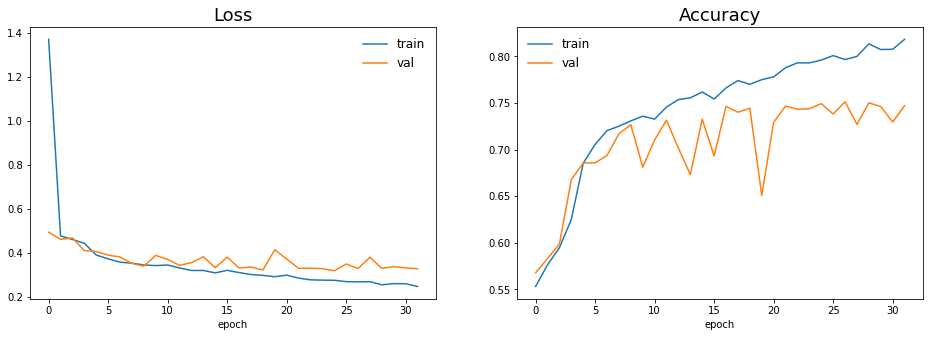

In [49]:
pa.plot_model_history(fitted_model)

**Without thresholds**

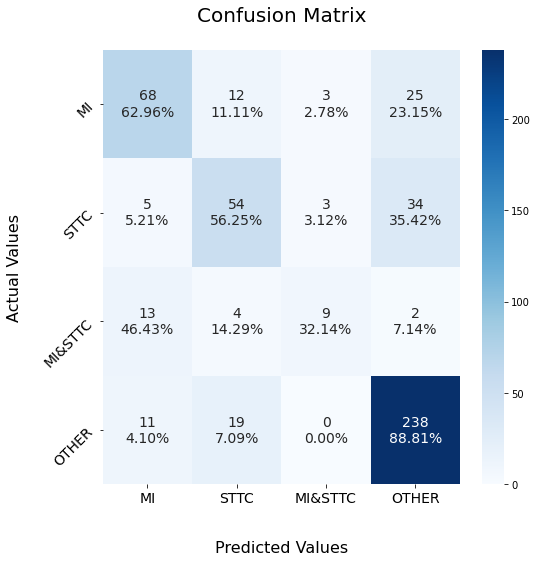

In [50]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

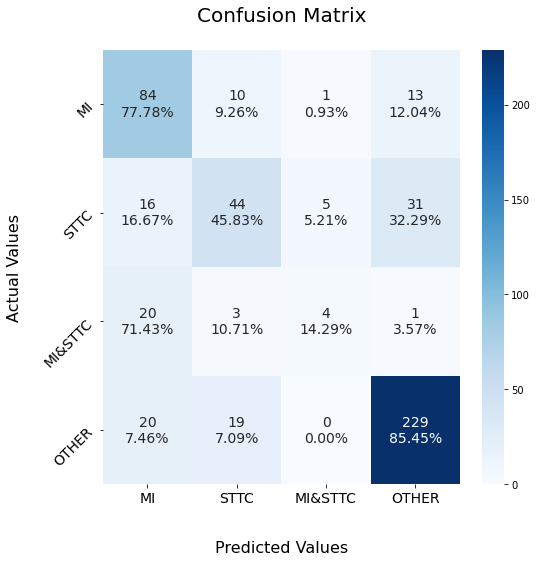

In [51]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer (playing with L1)

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [76]:
model_id = 'PTB-XL_labels/own/multibinary_bn_l1_5.h5'

Parameters

In [77]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [78]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006)),
            MaxPool1D(),
            BatchNormalization(),            

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 500, 128)          21632     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 250, 128)         0         
 g1D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 250, 128)         512       
 chNormalization)                                                
                                                                 
 conv1d_33 (Conv1D)          (None, 84, 256)           459008    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 42, 256)          0         
 g1D)                                                            
                                                      

In [80]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 8s 34ms/step - loss: 1.1487 - accuracy: 0.5596 - val_loss: 0.4707 - val_accuracy: 0.5744
Epoch 2/50
218/218 [==============================] - 8s 38ms/step - loss: 0.4291 - accuracy: 0.6018 - val_loss: 0.4070 - val_accuracy: 0.6162
Epoch 3/50
218/218 [==============================] - 9s 40ms/step - loss: 0.3948 - accuracy: 0.6459 - val_loss: 0.3811 - val_accuracy: 0.6629
Epoch 4/50
218/218 [==============================] - 8s 39ms/step - loss: 0.3722 - accuracy: 0.6896 - val_loss: 0.3717 - val_accuracy: 0.6674
Epoch 5/50
218/218 [==============================] - 8s 39ms/step - loss: 0.3800 - accuracy: 0.6984 - val_loss: 0.3562 - val_accuracy: 0.7132
Epoch 6/50
218/218 [==============================] - 9s 40ms/step - loss: 0.3414 - accuracy: 0.7240 - val_loss: 0.3447 - val_accuracy: 0.7095
Epoch 7/50
218/218 [==============================] - 8s 38ms/step - loss: 0.3320 - accuracy: 0.7310 - val_loss: 0.3378 - val_accuracy: 0.7192

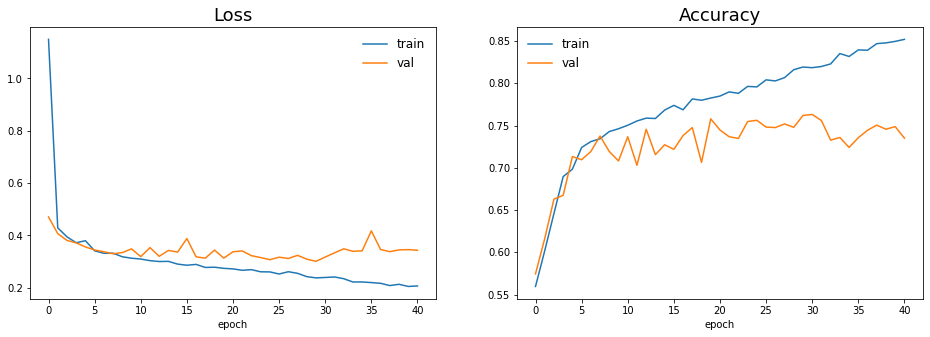

In [81]:
pa.plot_model_history(fitted_model)

**Without thresholds**

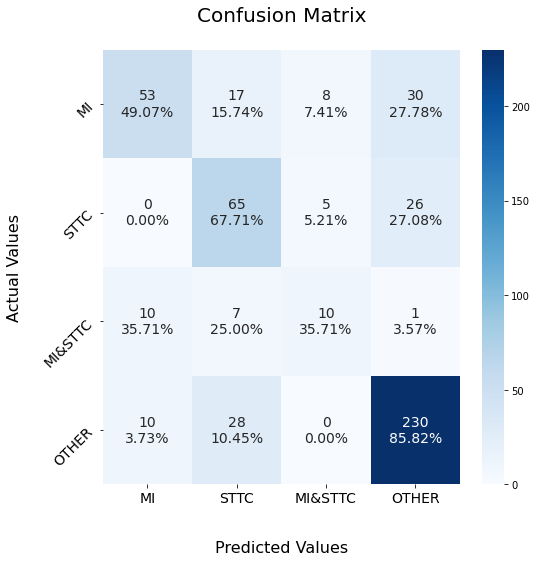

In [82]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

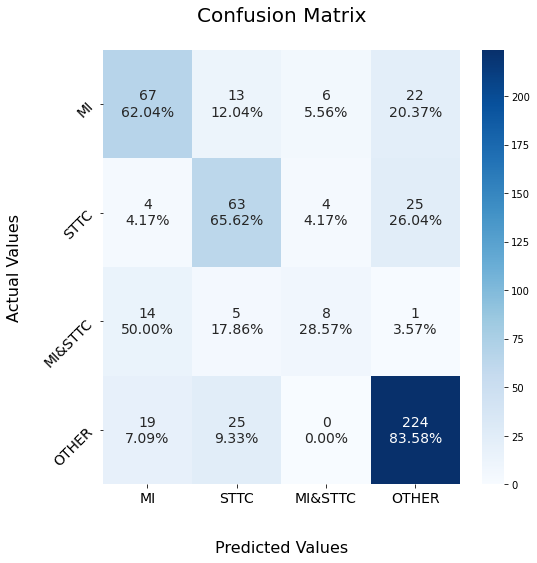

In [83]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Dropout

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [45]:
model_id = 'PTB-XL_labels/own/multibinary_bn_l1_dr_9.h5'

Parameters

In [46]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [47]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),                 
            BatchNormalization(),
            Dropout(rate=0.3),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),
            Dropout(rate=0.3),
        
            Conv1D(d_model, 10, activation='relu', strides=2, padding="same"),
            MaxPool1D(),            
            BatchNormalization(),    
            Dropout(rate=0.3),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006)),
            MaxPool1D(),            
            BatchNormalization(),            
            Dropout(rate=0.3),

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 500, 128)          21632     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 250, 128)         512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 250, 128)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 84, 256)           459008    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 42, 256)         

In [49]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches-1,
                               epochs=125, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=15)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/125
217/217 [==============================] - 9s 34ms/step - loss: 0.8943 - accuracy: 0.5603 - val_loss: 0.4614 - val_accuracy: 0.5790
Epoch 2/125
217/217 [==============================] - 8s 39ms/step - loss: 0.4311 - accuracy: 0.6077 - val_loss: 0.3918 - val_accuracy: 0.6325
Epoch 3/125
217/217 [==============================] - 10s 45ms/step - loss: 0.4091 - accuracy: 0.6342 - val_loss: 0.4174 - val_accuracy: 0.6540
Epoch 4/125
217/217 [==============================] - 9s 43ms/step - loss: 0.3938 - accuracy: 0.6511 - val_loss: 0.3574 - val_accuracy: 0.6774
Epoch 5/125
217/217 [==============================] - 9s 43ms/step - loss: 0.3736 - accuracy: 0.6850 - val_loss: 0.3511 - val_accuracy: 0.6955
Epoch 6/125
217/217 [==============================] - 9s 43ms/step - loss: 0.3644 - accuracy: 0.6891 - val_loss: 0.3778 - val_accuracy: 0.6869
Epoch 7/125
217/217 [==============================] - 9s 43ms/step - loss: 0.3580 - accuracy: 0.6971 - val_loss: 0.3351 - val_accuracy

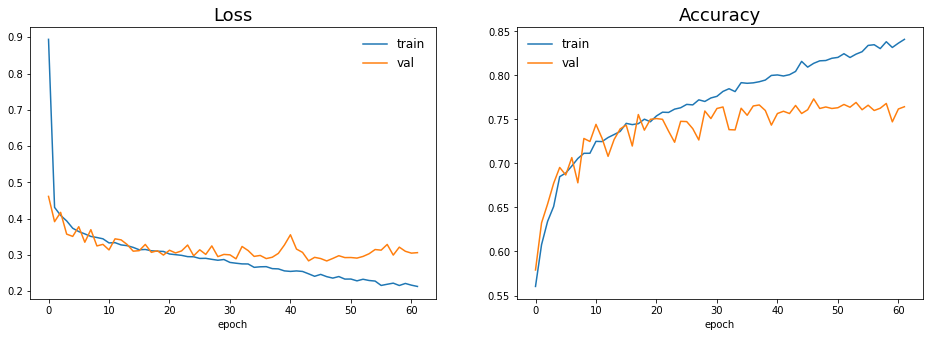

In [50]:
pa.plot_model_history(fitted_model)

**Without thresholds**

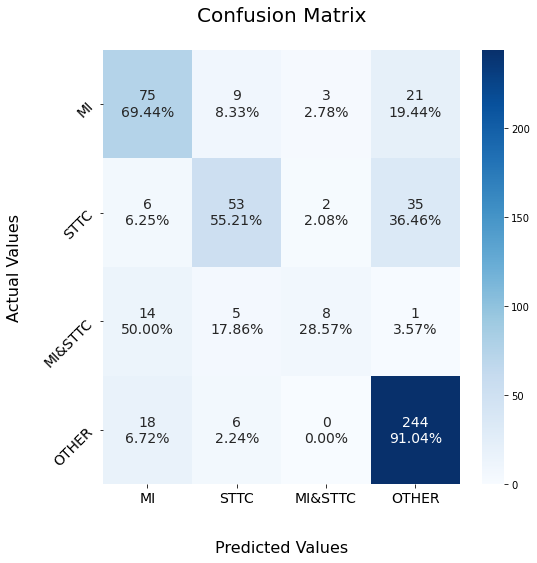

In [51]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

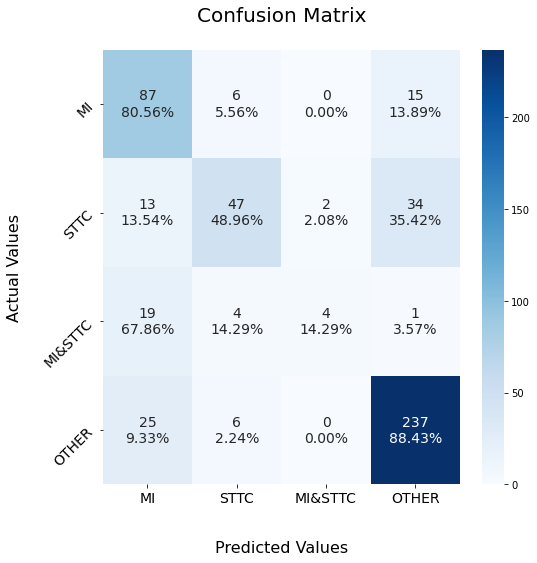

In [52]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Dropout + ResNet

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [98]:
model_id = 'PTB-XL_labels/own/multibinary_bn_l1_dr_rn_1.h5'

Parameters

In [99]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [100]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            Dropout(rate=0.2),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            Dropout(rate=0.2),
            BatchNormalization(),
        
            Conv1D(d_model, 10, activation='relu', strides=2, padding="same"),
            MaxPool1D(),
            Dropout(rate=0.2),
            BatchNormalization(),    

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006)),
            MaxPool1D(),
            Dropout(rate=0.2),
            BatchNormalization(),            

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

In [120]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    
    ### Convolutional Model
    conv_input = Input(shape=(img_h, img_w))

    x = Conv1D(128, 14, activation='relu', strides=3, padding="same")(conv_input)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(256, 14, activation='relu', strides=3, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006))(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Model(inputs = conv_input, outputs = x)
    
    
    ### Age and Sex Model
    wide_input = Input(shape=(2,))    
    y = Dense(10, activation='relu')(wide_input)    
    y = Model(inputs = wide_input, outputs = y)
    
    
    ### Combined Model
    combined = concatenate([x.output, y.output])
    z = Dense(d_model, activation='relu')(combined)
    z = Dense(4, activation='sigmoid')(z)

    model = Model(inputs=[x.input, y.input], outputs=z)

In [182]:
conv_input = Input(shape=(img_h, img_w))

x = Conv1D(128, 14, strides=1, padding="same", use_bias=False)(conv_input)
x = BatchNormalization()(x)
x = ReLU()(x)

x, y = x, x

n_samples_in = y.shape[1]
n_samples_out = 1024
# downsample = n_samples_in // n_samples_out
n_filters_in = y.shape[2]
n_filters_out = 128
kernel_size = 17

# y = self._skip_connection(y, downsample, n_filters_in)

x = Conv1D(n_filters_out, kernel_size, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

x = Conv1D(n_filters_out, kernel_size, padding="same", use_bias=False)(x)

x = Add()([x,y])

y = x

x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

###

n_samples_in = y.shape[1]
n_samples_out = 1024
# downsample = n_samples_in // n_samples_out
n_filters_in = y.shape[2]
n_filters_out = 128
kernel_size = 17

# y = self._skip_connection(y, downsample, n_filters_in)

x = Conv1D(n_filters_out, kernel_size, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

x = Conv1D(n_filters_out, kernel_size, padding="same", use_bias=False)(x)

x = Add()([x,y])

y = x

x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

# x = Flatten()(x)
# # x = Dense()
# x = Model(inputs = conv_input, outputs = x)

# x, y = ResidualUnit(1024, 128, kernel_size=kernel_size,
#                     kernel_initializer=kernel_initializer)([x, x])

#####################################################################################

# xx = Conv1D(128, 1, strides=2, padding="same")(conv_input)
# xx = MaxPool1D()(xx)
# # xx = Dropout(rate=0.3)(xx)
# xx = BatchNormalization()(xx)
# xx = ReLU()(xx)

# xx = Conv1D(256, 14, strides=3, padding="same")(xx)
# xx = MaxPool1D()(xx)
# xx = Dropout(rate=0.3)(xx)
# xx = BatchNormalization()(xx)
# xx = ReLU()(xx)

# xx = Flatten()(xx)

# x = add([x, xx])

# xx = Model(inputs = conv_input, outputs = xx)

In [186]:
x.get_shape()

TensorShape([None, 1500, 128])

In [187]:
y.get_shape()

TensorShape([None, 1500, 128])

In [180]:
x.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 1500, 12)]   0           []                               
                                                                                                  
 conv1d_102 (Conv1D)            (None, 1500, 128)    21504       ['input_46[0][0]']               
                                                                                                  
 batch_normalization_68 (BatchN  (None, 1500, 128)   512         ['conv1d_102[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 re_lu_32 (ReLU)                (None, 1500, 128)    0           ['batch_normalization_68[0

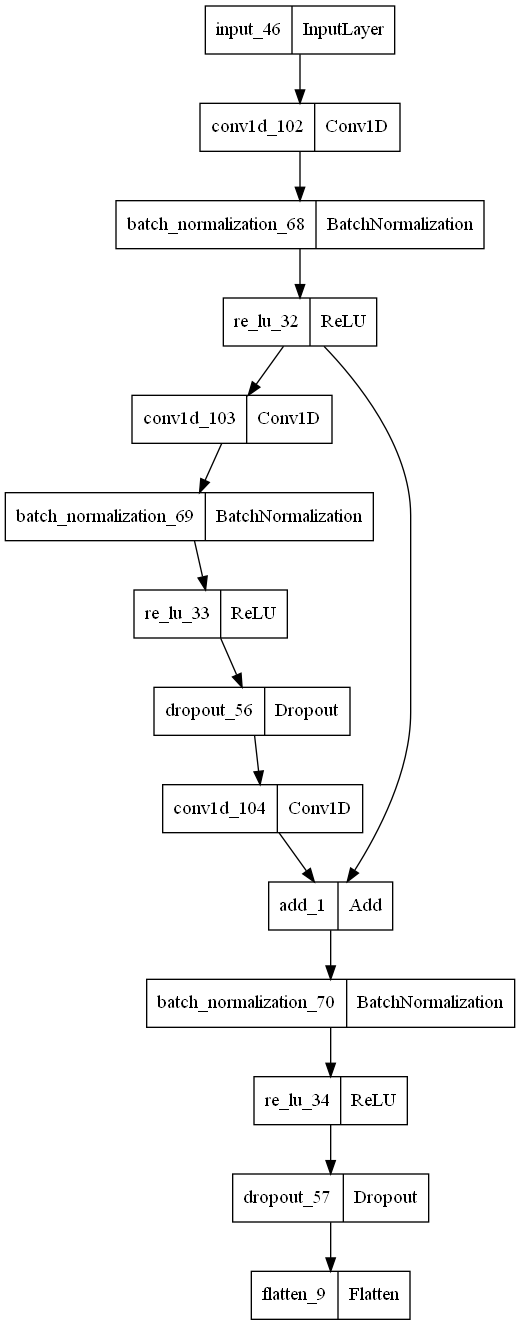

In [181]:
plot_model(x)

In [119]:
x

<KerasTensor: shape=(None, 1500, 256) dtype=float32 (created by layer 'conv1d_47')>

In [110]:
from tensorflow.keras.utils import plot_model

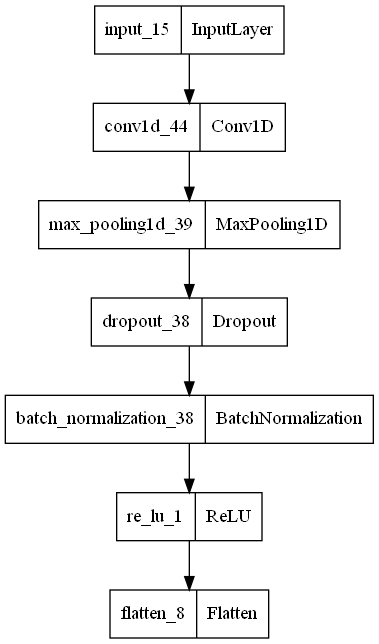

In [112]:
plot_model(x)

Summary.

In [109]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1500, 12)]   0           []                               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 500, 128)     21632       ['input_12[0][0]']               
                                                                                                  
 max_pooling1d_32 (MaxPooling1D  (None, 250, 128)    0           ['conv1d_36[0][0]']              
 )                                                                                                
                                                                                                  
 dropout_30 (Dropout)           (None, 250, 128)     0           ['max_pooling1d_32[0][0]']

 dense_7 (Dense)                (None, 4)            1028        ['dense_6[0][0]']                
                                                                                                  
Total params: 2,334,468
Trainable params: 2,331,396
Non-trainable params: 3,072
__________________________________________________________________________________________________


In [102]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 11s 46ms/step - loss: 0.7719 - accuracy: 0.5622 - val_loss: 0.4523 - val_accuracy: 0.5767
Epoch 2/50
218/218 [==============================] - 10s 47ms/step - loss: 0.4170 - accuracy: 0.6125 - val_loss: 0.3889 - val_accuracy: 0.6279
Epoch 3/50
218/218 [==============================] - 11s 48ms/step - loss: 0.3968 - accuracy: 0.6327 - val_loss: 0.3987 - val_accuracy: 0.6483
Epoch 4/50
218/218 [==============================] - 11s 48ms/step - loss: 0.3752 - accuracy: 0.6735 - val_loss: 0.3357 - val_accuracy: 0.7101
Epoch 5/50
218/218 [==============================] - 11s 48ms/step - loss: 0.3595 - accuracy: 0.6907 - val_loss: 0.3766 - val_accuracy: 0.6926
Epoch 6/50
218/218 [==============================] - 11s 51ms/step - loss: 0.3539 - accuracy: 0.7007 - val_loss: 0.3265 - val_accuracy: 0.7221
Epoch 7/50
218/218 [==============================] - 12s 53ms/step - loss: 0.3437 - accuracy: 0.7115 - val_loss: 0.3647 - val_accuracy:

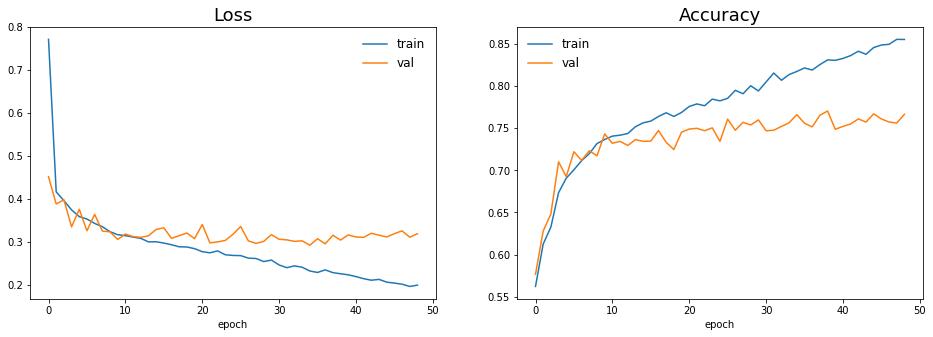

In [103]:
pa.plot_model_history(fitted_model)

**Without thresholds**

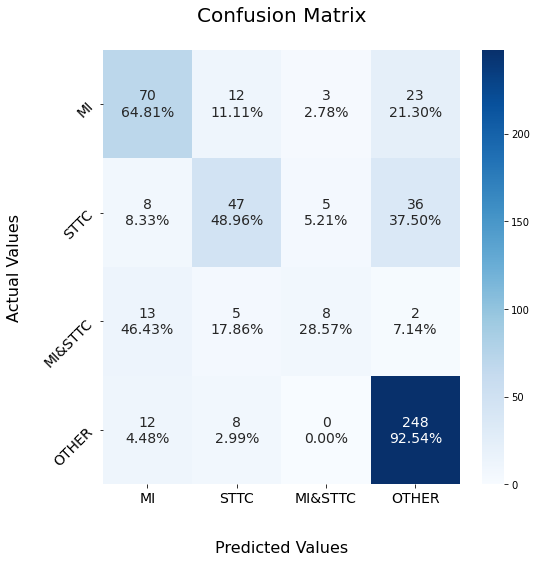

In [104]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

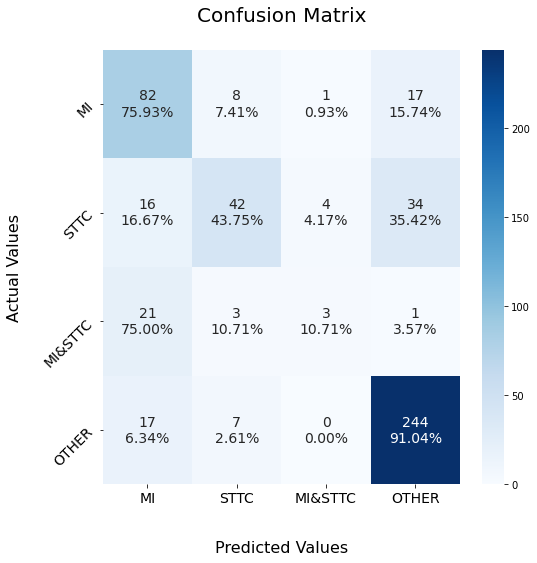

In [105]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Dropout + Age + Sex

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [118]:
model_id = 'PTB-XL_labels/fir_m1_p1/multibinary_bn_l1_dr_as_3.h5'

Parameters

In [119]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [120]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    
    ### Convolutional Model
    conv_input = Input(shape=(img_h, img_w))

    x = Conv1D(128, 14, activation='relu', strides=3, padding="same")(conv_input)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(256, 14, activation='relu', strides=3, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006))(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Model(inputs = conv_input, outputs = x)
    
    
    ### Age and Sex Model
    wide_input = Input(shape=(2,))    
    y = Dense(10, activation='relu')(wide_input)    
    y = Model(inputs = wide_input, outputs = y)
    
    
    ### Combined Model
    combined = concatenate([x.output, y.output])
    z = Dense(d_model, activation='relu')(combined)
    z = Dense(4, activation='sigmoid')(z)

    model = Model(inputs=[x.input, y.input], outputs=z)

Summary.

In [121]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1500, 12)]   0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 500, 128)     21632       ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 250, 128)    0           ['conv1d_3[0][0]']               
                                                                                                  
 dropout (Dropout)              (None, 250, 128)     0           ['max_pooling1d_3[0][0]']        
                                                                                            

In [122]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit((train_set_x, train_set_age_n_sex), train_set_y, steps_per_epoch=batches,
                               epochs=100, validation_data=((val_set_x, val_set_age_n_sex), val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=15)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/100
218/218 [==============================] - 13s 47ms/step - loss: 0.7781 - accuracy: 0.5497 - val_loss: 0.4954 - val_accuracy: 0.5713
Epoch 2/100
218/218 [==============================] - 10s 44ms/step - loss: 0.4465 - accuracy: 0.5794 - val_loss: 0.4460 - val_accuracy: 0.5821
Epoch 3/100
218/218 [==============================] - 10s 45ms/step - loss: 0.4234 - accuracy: 0.5995 - val_loss: 0.3948 - val_accuracy: 0.6271
Epoch 4/100
218/218 [==============================] - 10s 45ms/step - loss: 0.4183 - accuracy: 0.6049 - val_loss: 0.4082 - val_accuracy: 0.6148
Epoch 5/100
218/218 [==============================] - 10s 45ms/step - loss: 0.4046 - accuracy: 0.6246 - val_loss: 0.3855 - val_accuracy: 0.6448
Epoch 6/100
218/218 [==============================] - 10s 46ms/step - loss: 0.4064 - accuracy: 0.6275 - val_loss: 0.4006 - val_accuracy: 0.6216
Epoch 7/100
218/218 [==============================] - 10s 46ms/step - loss: 0.3937 - accuracy: 0.6435 - val_loss: 0.3800 - val_ac

Epoch 57/100
218/218 [==============================] - 40s 183ms/step - loss: 0.2787 - accuracy: 0.7722 - val_loss: 0.3073 - val_accuracy: 0.7521
Epoch 58/100
218/218 [==============================] - 40s 183ms/step - loss: 0.2833 - accuracy: 0.7704 - val_loss: 0.3130 - val_accuracy: 0.7424
Epoch 59/100
218/218 [==============================] - 40s 183ms/step - loss: 0.2790 - accuracy: 0.7734 - val_loss: 0.3226 - val_accuracy: 0.7252
Epoch 60/100
218/218 [==============================] - 40s 182ms/step - loss: 0.2801 - accuracy: 0.7700 - val_loss: 0.3028 - val_accuracy: 0.7441
Epoch 61/100
218/218 [==============================] - 40s 184ms/step - loss: 0.2727 - accuracy: 0.7812 - val_loss: 0.3008 - val_accuracy: 0.7467
Epoch 62/100
218/218 [==============================] - 41s 186ms/step - loss: 0.2741 - accuracy: 0.7772 - val_loss: 0.3033 - val_accuracy: 0.7413
Epoch 63/100
218/218 [==============================] - 40s 183ms/step - loss: 0.2760 - accuracy: 0.7799 - val_loss: 0

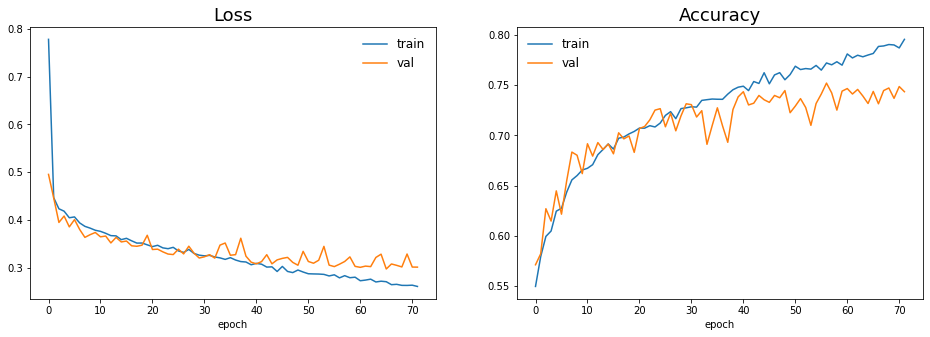

In [124]:
pa.plot_model_history(fitted_model)

**Without thresholds**

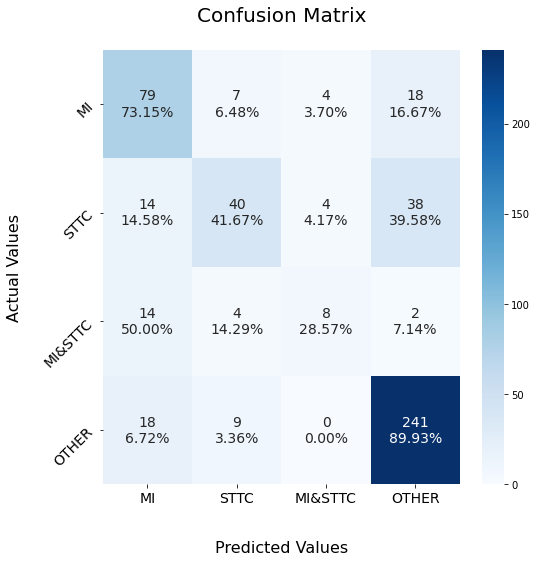

In [125]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

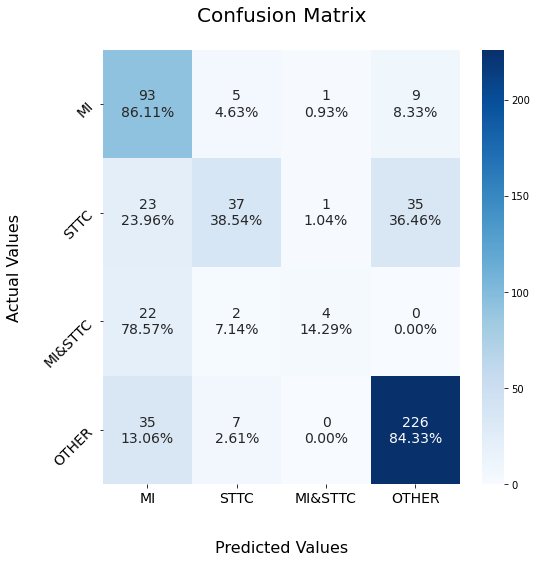

In [126]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + LR Reduce

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [107]:
model_id = 'PTB-XL_labels/own/multibinary_bn_l1_lr_1.h5'

Parameters

In [108]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

Load the model if it has been created, else create a new instance of it.

In [109]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.01)),
            MaxPool1D(),
            BatchNormalization(),            

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [110]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 500, 128)          21632     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 250, 128)         0         
 g1D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 250, 128)         512       
 chNormalization)                                                
                                                                 
 conv1d_13 (Conv1D)          (None, 84, 256)           459008    
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 42, 256)          0         
 g1D)                                                            
                                                      

In [111]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5), reduce_lr])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 10s 41ms/step - loss: 1.3880 - accuracy: 0.5559 - val_loss: 0.4751 - val_accuracy: 0.5764 - lr: 0.0010
Epoch 2/50
217/218 [============================>.] - ETA: 0s - loss: 0.4310 - accuracy: 0.6095
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
218/218 [==============================] - 9s 42ms/step - loss: 0.4306 - accuracy: 0.6100 - val_loss: 0.3932 - val_accuracy: 0.6451 - lr: 0.0010
Epoch 3/50
217/218 [============================>.] - ETA: 0s - loss: 0.3848 - accuracy: 0.6515
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
218/218 [==============================] - 9s 41ms/step - loss: 0.3848 - accuracy: 0.6518 - val_loss: 0.3829 - val_accuracy: 0.6448 - lr: 1.0000e-04
Epoch 4/50
217/218 [============================>.] - ETA: 0s - loss: 0.3768 - accuracy: 0.6565
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
218/218 [=====================

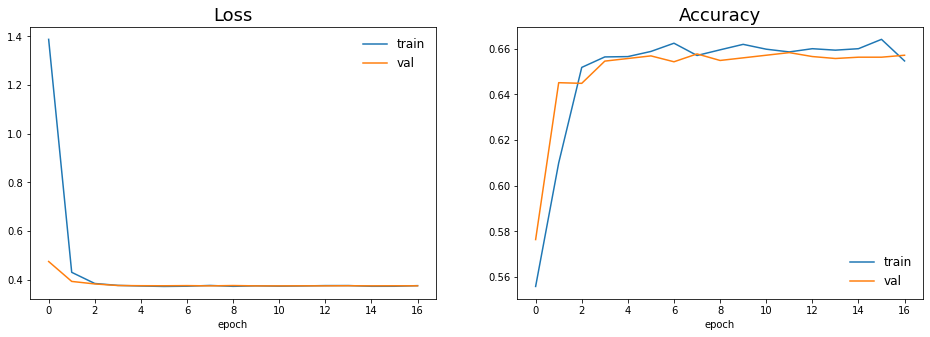

In [112]:
pa.plot_model_history(fitted_model)

**Without thresholds**

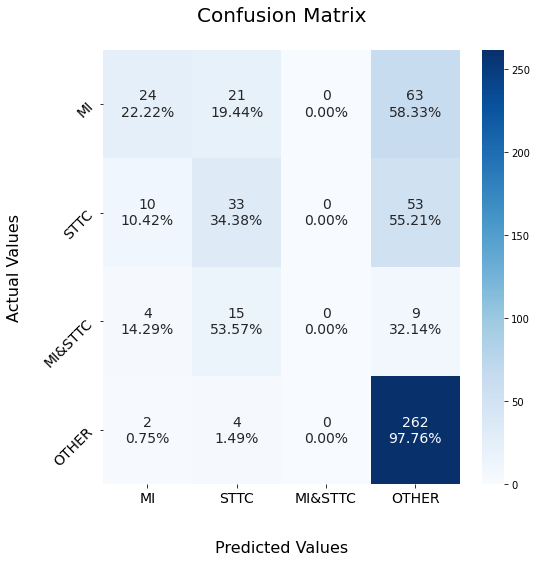

In [113]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

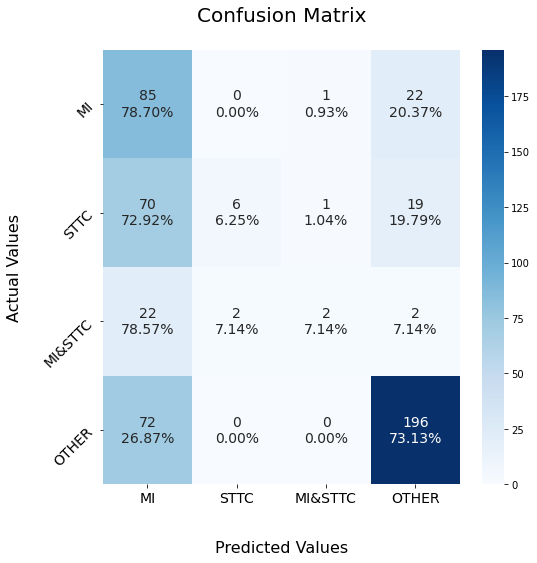

In [114]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Class Weights

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [96]:
model_id = 'PTB-XL_labels/own/multibinary_bn_l1_cw_lr_1.h5'

Parameters

In [97]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

weights = md.calculating_class_weights(np.array(strat_df.drop(['label'], 1)))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

Load the model if it has been created, else create a new instance of it.

In [98]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.01)),
            MaxPool1D(),
            BatchNormalization(),

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [99]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 500, 128)          21632     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 250, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_10 (Conv1D)          (None, 84, 256)           459008    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 42, 256)          0         
 1D)                                                             
                                                      

In [100]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),
                               class_weight=weights,
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5), reduce_lr])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 9s 33ms/step - loss: 2.8388 - accuracy: 0.4020 - val_loss: 0.6479 - val_accuracy: 0.1749 - lr: 0.0010
Epoch 2/50
217/218 [============================>.] - ETA: 0s - loss: 1.1197 - accuracy: 0.4710
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
218/218 [==============================] - 8s 36ms/step - loss: 1.1212 - accuracy: 0.4711 - val_loss: 0.6148 - val_accuracy: 0.4768 - lr: 0.0010
Epoch 3/50
217/218 [============================>.] - ETA: 0s - loss: 1.0204 - accuracy: 0.5246
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
218/218 [==============================] - 8s 36ms/step - loss: 1.0206 - accuracy: 0.5248 - val_loss: 0.4410 - val_accuracy: 0.5827 - lr: 1.0000e-04
Epoch 4/50
217/218 [============================>.] - ETA: 0s - loss: 0.9650 - accuracy: 0.5734
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
218/218 [======================

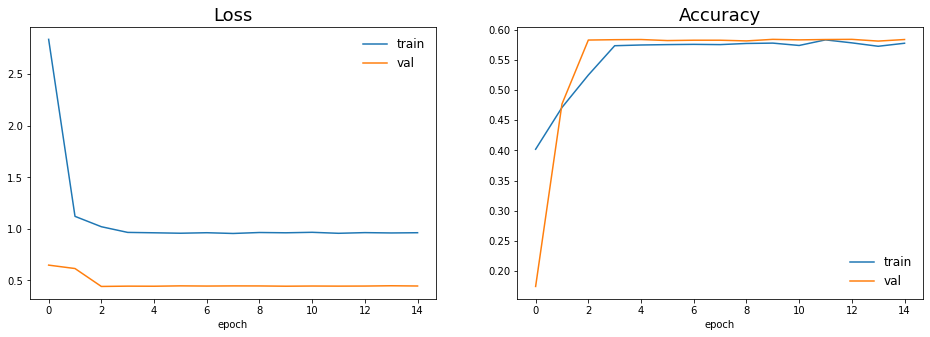

In [101]:
pa.plot_model_history(fitted_model)

**Without thresholds**

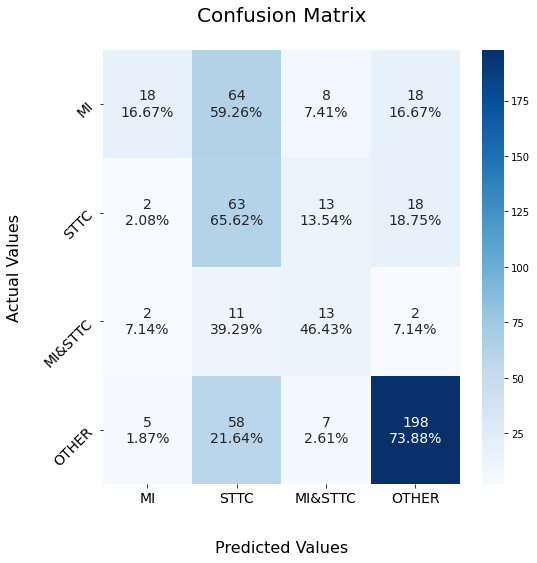

In [102]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

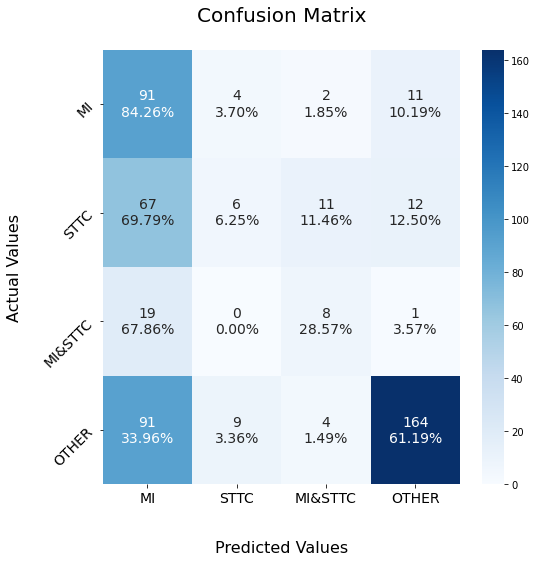

In [104]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Class Weights

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [132]:
model_id = 'PTB-XL_labels/fir_m1_p1/multibinary_bn_l1_cw_1.h5'

Parameters

In [84]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

weights = md.calculating_class_weights(np.array(strat_df.drop(['label'], 1)))

Load the model if it has been created, else create a new instance of it.

In [85]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.01)),
            MaxPool1D(),
            BatchNormalization(),            

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [86]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 500, 128)          21632     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 250, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 84, 256)           459008    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 42, 256)          0         
 1D)                                                             
                                                      

In [87]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),  
                               class_weight=weights,
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 7s 28ms/step - loss: 2.8694 - accuracy: 0.2831 - val_loss: 0.5729 - val_accuracy: 0.4888
Epoch 2/50
218/218 [==============================] - 6s 26ms/step - loss: 1.1455 - accuracy: 0.2709 - val_loss: 0.5818 - val_accuracy: 0.1709
Epoch 3/50
218/218 [==============================] - 6s 26ms/step - loss: 1.1566 - accuracy: 0.2406 - val_loss: 0.5887 - val_accuracy: 0.4013
Epoch 4/50
218/218 [==============================] - 6s 29ms/step - loss: 1.1349 - accuracy: 0.2587 - val_loss: 0.5576 - val_accuracy: 0.5710
Epoch 5/50
218/218 [==============================] - 7s 34ms/step - loss: 1.1327 - accuracy: 0.2875 - val_loss: 0.5821 - val_accuracy: 0.1955
Epoch 6/50
218/218 [==============================] - 8s 35ms/step - loss: 1.1325 - accuracy: 0.3689 - val_loss: 0.5468 - val_accuracy: 0.5587
Epoch 7/50
218/218 [==============================] - 8s 35ms/step - loss: 1.1290 - accuracy: 0.4013 - val_loss: 0.5679 - val_accuracy: 0.5243

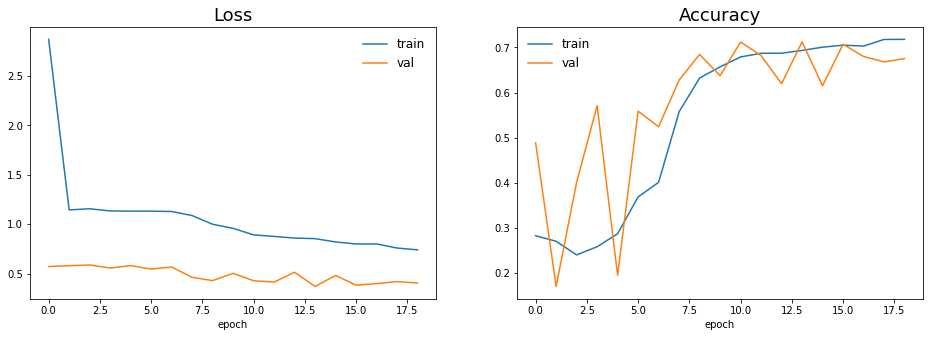

In [93]:
pa.plot_model_history(fitted_model)

In [92]:
fitted_model = pd.DataFrame(fitted_model.history)
fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

**Without thresholds**

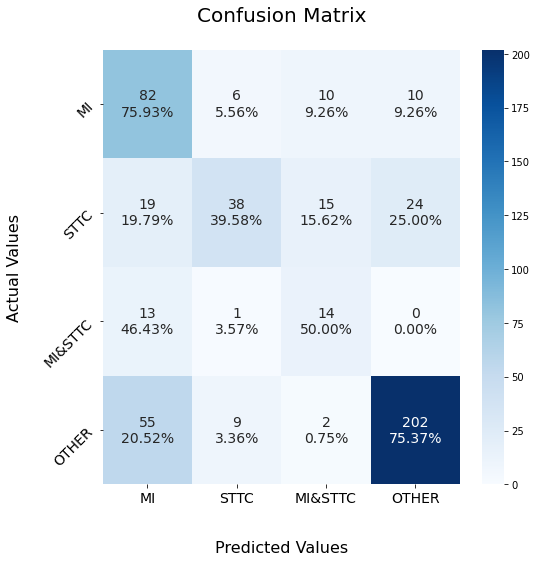

In [94]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

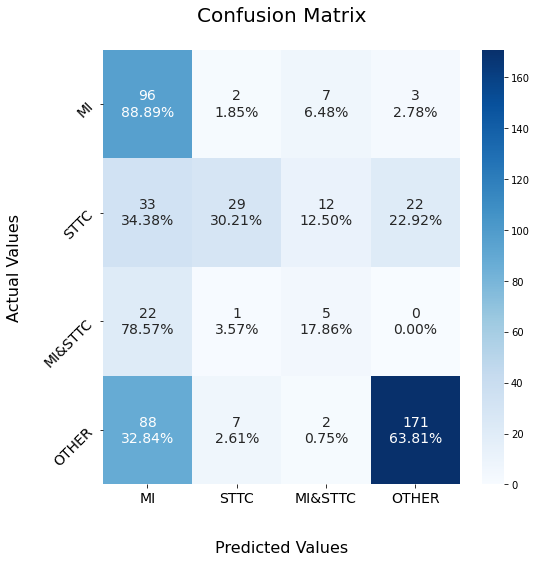

In [95]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Class Weights + Droput

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [140]:
model_id = 'PTB-XL_labels/fir_m1_p1/multibinary_bn_l1_dr_cw_1.h5'

Parameters

In [141]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

weights = md.calculating_class_weights(np.array(strat_df.drop(['label'], 1)))

Load the model if it has been created, else create a new instance of it.

In [142]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            Dropout(rate=0.3),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            Dropout(rate=0.3),
            BatchNormalization(),
        
            Conv1D(d_model, 10, activation='relu', strides=2, padding="same"),
            MaxPool1D(),
            Dropout(rate=0.3),
            BatchNormalization(), 

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006)),
            MaxPool1D(),
            Dropout(rate=0.3),
            BatchNormalization(),            

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [144]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 500, 128)          21632     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 250, 128)         0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 250, 128)          0         
                                                                 
 batch_normalization_12 (Bat  (None, 250, 128)         512       
 chNormalization)                                                
                                                                 
 conv1d_16 (Conv1D)          (None, 84, 256)           459008    
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 42, 256)         

In [146]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=100, validation_data=(val_set_x, val_set_y),  
                               class_weight=weights,
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=15)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/100
218/218 [==============================] - 12s 47ms/step - loss: 0.9680 - accuracy: 0.5425 - val_loss: 0.4270 - val_accuracy: 0.6772
Epoch 2/100
218/218 [==============================] - 10s 48ms/step - loss: 0.9526 - accuracy: 0.5639 - val_loss: 0.4582 - val_accuracy: 0.5973
Epoch 3/100
218/218 [==============================] - 10s 47ms/step - loss: 0.9518 - accuracy: 0.5780 - val_loss: 0.3917 - val_accuracy: 0.6740
Epoch 4/100
218/218 [==============================] - 11s 49ms/step - loss: 0.9277 - accuracy: 0.5680 - val_loss: 0.4560 - val_accuracy: 0.5180
Epoch 5/100
218/218 [==============================] - 10s 48ms/step - loss: 0.9235 - accuracy: 0.5655 - val_loss: 0.4311 - val_accuracy: 0.6534
Epoch 6/100
218/218 [==============================] - 10s 48ms/step - loss: 0.9170 - accuracy: 0.5894 - val_loss: 0.4515 - val_accuracy: 0.5970
Epoch 7/100
218/218 [==============================] - 10s 48ms/step - loss: 0.9016 - accuracy: 0.5851 - val_loss: 0.4099 - val_ac

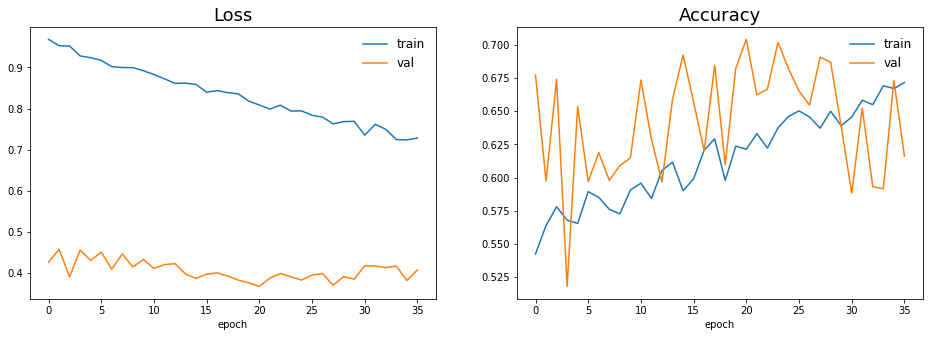

In [147]:
pa.plot_model_history(fitted_model)

**Without thresholds**

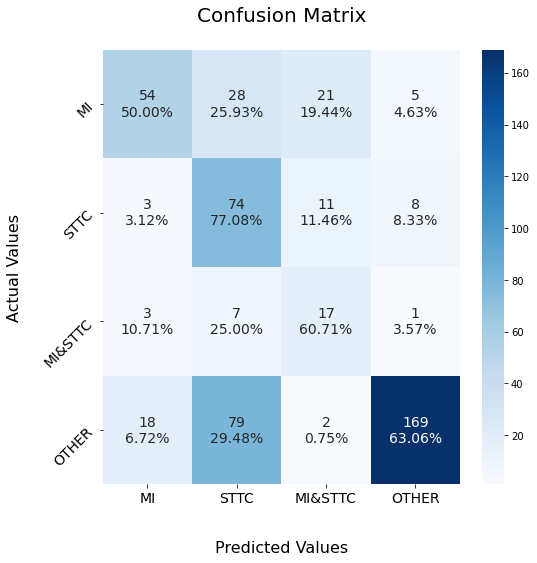

In [148]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

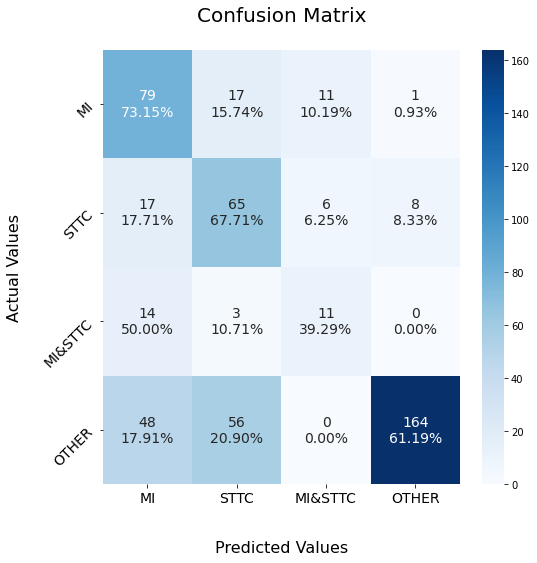

In [149]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Class Weights + Change order of Batch and ReLu

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [150]:
model_id = 'PTB-XL_labels/fir_m1_p1/multibinary_bn_l1_cw_2.h5'

Parameters

In [151]:
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

weights = md.calculating_class_weights(np.array(strat_df.drop(['label'], 1)))

Load the model if it has been created, else create a new instance of it.

In [152]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, strides=3, padding="same"),
            BatchNormalization(),
            ReLU(),
            MaxPool1D(),        

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            BatchNormalization(),
            ReLU(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.01)),
            BatchNormalization(),
            ReLU(),

            Flatten(),
            Dense(64, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [153]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 500, 128)          21632     
                                                                 
 batch_normalization_16 (Bat  (None, 500, 128)         512       
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                (None, 500, 128)          0         
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 250, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 84, 256)           459008    
                                                                 
 batch_normalization_17 (Bat  (None, 84, 256)         

In [155]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=100, validation_data=(val_set_x, val_set_y),
                               class_weight=weights, 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=15)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/100
218/218 [==============================] - 11s 45ms/step - loss: 1.2608 - accuracy: 0.4166 - val_loss: 0.5255 - val_accuracy: 0.4545
Epoch 2/100
218/218 [==============================] - 9s 43ms/step - loss: 1.0142 - accuracy: 0.5085 - val_loss: 0.5000 - val_accuracy: 0.4851
Epoch 3/100
218/218 [==============================] - 10s 45ms/step - loss: 0.9628 - accuracy: 0.5424 - val_loss: 0.4974 - val_accuracy: 0.4874
Epoch 4/100
218/218 [==============================] - 10s 45ms/step - loss: 0.9240 - accuracy: 0.5572 - val_loss: 0.4766 - val_accuracy: 0.5458
Epoch 5/100
218/218 [==============================] - 10s 45ms/step - loss: 0.8895 - accuracy: 0.5799 - val_loss: 0.4433 - val_accuracy: 0.5707
Epoch 6/100
218/218 [==============================] - 10s 46ms/step - loss: 0.8636 - accuracy: 0.5940 - val_loss: 0.4954 - val_accuracy: 0.5541
Epoch 7/100
218/218 [==============================] - 14s 66ms/step - loss: 0.8230 - accuracy: 0.6150 - val_loss: 0.5061 - val_acc

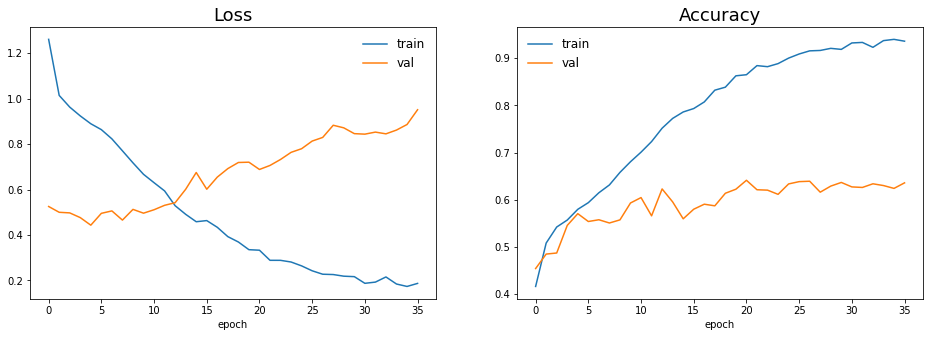

In [156]:
pa.plot_model_history(fitted_model)

**Without thresholds**

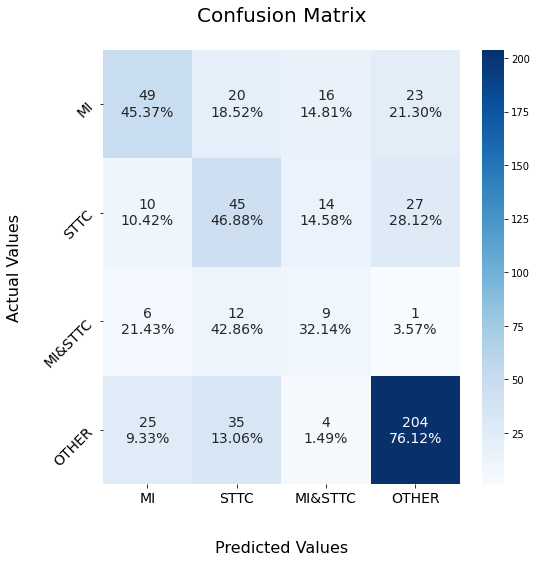

In [157]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

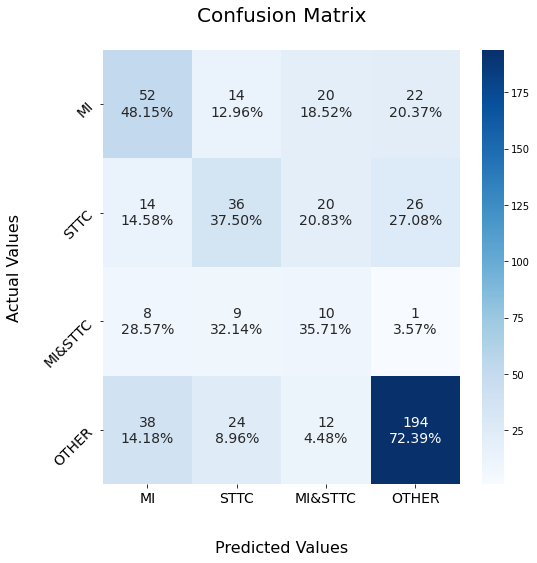

In [158]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Class Weights + Dropout + Change order of Batch and ReLu

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [164]:
model_id = 'PTB-XL_labels/fir_m1_p1/multibinary_bn_l1_dr_cw_2.h5'

Parameters

In [165]:
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

weights = md.calculating_class_weights(np.array(strat_df.drop(['label'], 1)))

Load the model if it has been created, else create a new instance of it.

In [166]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, strides=3, padding="same"),
            BatchNormalization(),
            ReLU(),
            MaxPool1D(),
            Dropout(0.3),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            BatchNormalization(),
            ReLU(),
            MaxPool1D(),
            Dropout(0.3),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006)),
            BatchNormalization(),
            ReLU(),
            MaxPool1D(),
            Dropout(0.3),

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(4, activation='sigmoid')
        ])

Summary.

In [167]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 500, 128)          21632     
                                                                 
 batch_normalization_19 (Bat  (None, 500, 128)         512       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 500, 128)          0         
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 250, 128)         0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 250, 128)          0         
                                                                 
 conv1d_23 (Conv1D)          (None, 84, 256)          

In [173]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=100, validation_data=(val_set_x, val_set_y),
                               class_weight=weights, 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=15)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

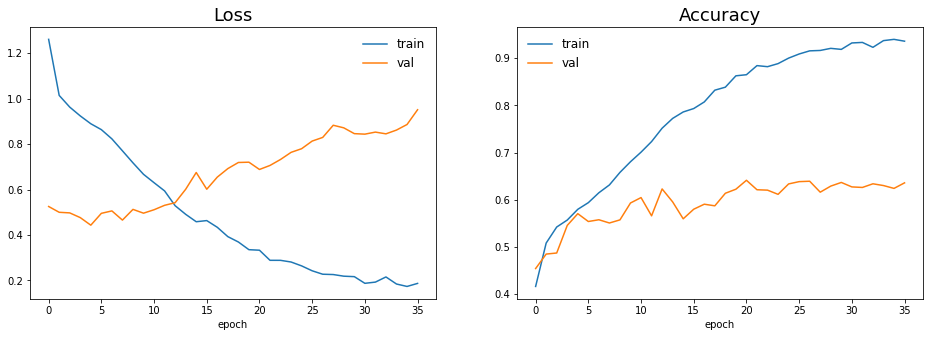

In [156]:
pa.plot_model_history(fitted_model)

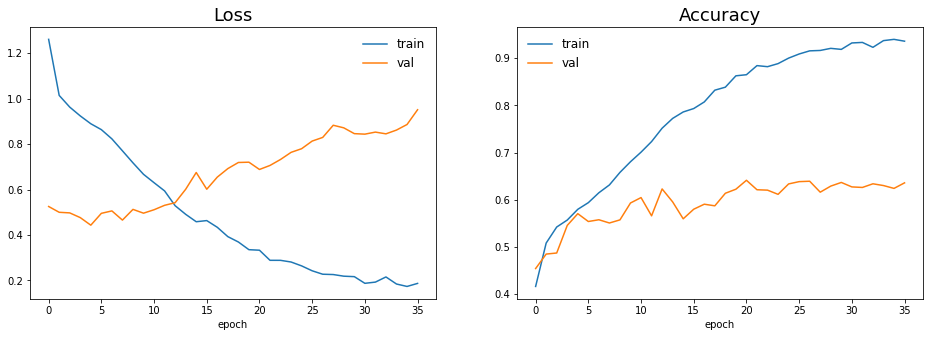

In [156]:
pa.plot_model_history(fitted_model)

**Without thresholds**

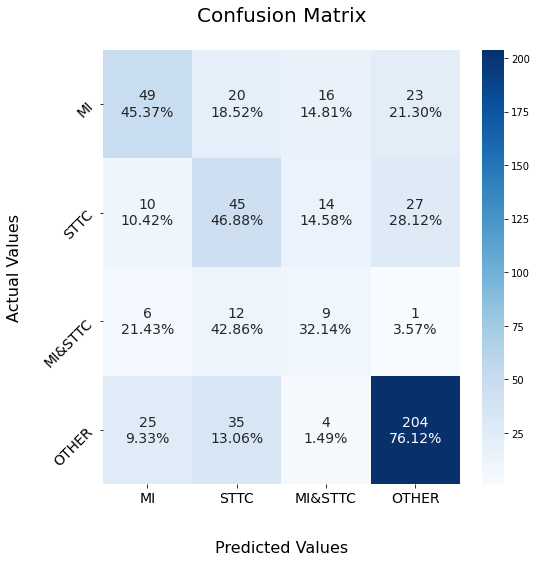

In [157]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

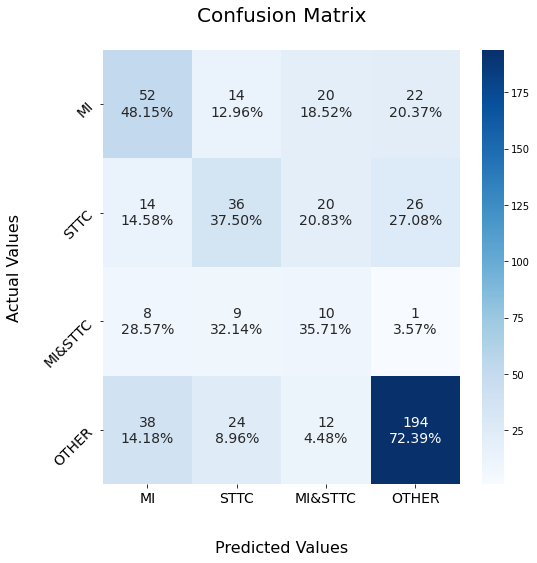

In [158]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

####  Multibinary - https://www.nature.com/articles/s41467-020-15432-4

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [42]:
model_id = 'PTB-XL_labels/antonior92/multibinary_original.h5'

Parameters

In [43]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256

optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [44]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = get_model(4, input_shape=(img_h, img_w))

Summary.

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 1500, 12)]   0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 1500, 64)     12288       ['signal[0][0]']                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 1500, 64)    256         ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 1500, 64)     0           ['batch_normalization_3[0][0]

 dropout_5 (Dropout)            (None, 75, 256)      0           ['activation_6[0][0]']           
                                                                                                  
 conv1d_14 (Conv1D)             (None, 75, 320)      1310720     ['dropout_5[0][0]']              
                                                                                                  
 batch_normalization_10 (BatchN  (None, 75, 320)     1280        ['conv1d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_7 (Activation)      (None, 75, 320)      0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 dropout_6 (Dropout)            (None, 75, 320)      0           ['activation_7[0][0]']           
          

In [46]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                               
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 204s 915ms/step - loss: 0.4001 - accuracy: 0.6498 - val_loss: 0.3508 - val_accuracy: 0.7029
Epoch 2/50
218/218 [==============================] - 333s 2s/step - loss: 0.3205 - accuracy: 0.7258 - val_loss: 0.3062 - val_accuracy: 0.7490
Epoch 3/50
218/218 [==============================] - 345s 2s/step - loss: 0.2909 - accuracy: 0.7488 - val_loss: 0.2939 - val_accuracy: 0.7444
Epoch 4/50
218/218 [==============================] - 354s 2s/step - loss: 0.2745 - accuracy: 0.7618 - val_loss: 0.2678 - val_accuracy: 0.7748
Epoch 5/50
218/218 [==============================] - 339s 2s/step - loss: 0.2603 - accuracy: 0.7802 - val_loss: 0.2840 - val_accuracy: 0.7650
Epoch 6/50
218/218 [==============================] - 313s 1s/step - loss: 0.2475 - accuracy: 0.7898 - val_loss: 0.2780 - val_accuracy: 0.7705
Epoch 7/50
218/218 [==============================] - 387s 2s/step - loss: 0.2417 - accuracy: 0.7968 - val_loss: 0.2650 - val_accuracy: 0.7

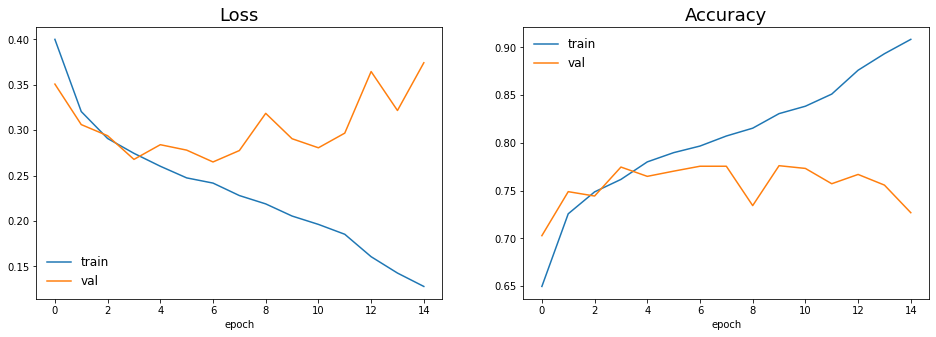

In [47]:
pa.plot_model_history(fitted_model)

**Without thresholds**

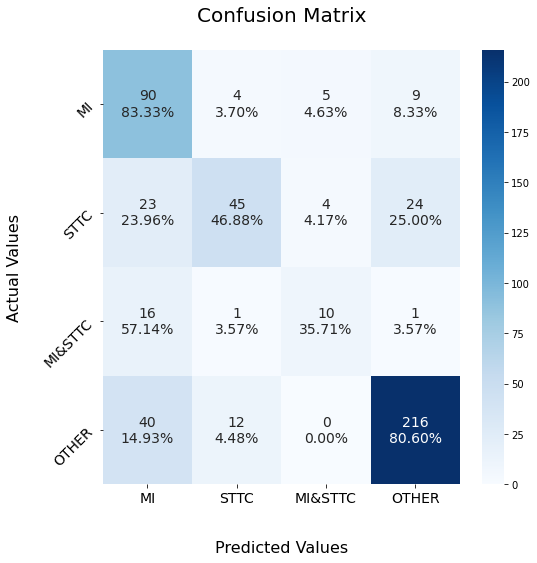

In [48]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

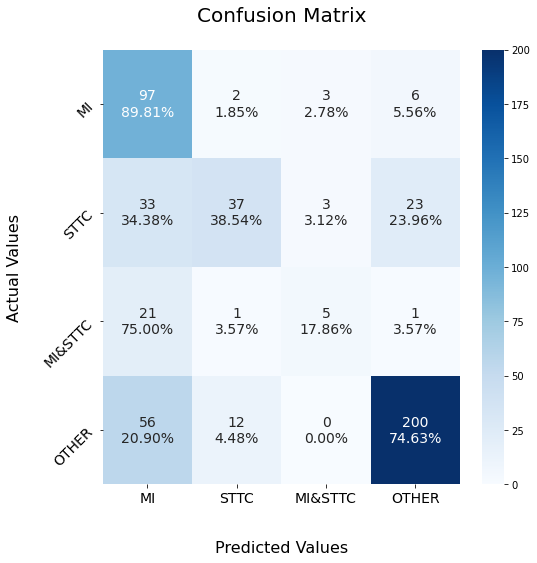

In [49]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - https://www.nature.com/articles/s41467-020-15432-4 + Weights + ReduceRL

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [57]:
model_id = 'PTB-XL_labels/antonior92/multibinary_cw_lr.h5'

Parameters

In [58]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

weights = md.calculating_class_weights(np.array(strat_df.drop(['label'], 1)))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

Load the model if it has been created, else create a new instance of it.

In [59]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = get_model(4, input_shape=(img_h, img_w))

Summary.

In [60]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 1500, 12)]   0           []                               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 1500, 64)     12288       ['signal[0][0]']                 
                                                                                                  
 batch_normalization_12 (BatchN  (None, 1500, 64)    256         ['conv1d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 1500, 64)     0           ['batch_normalization_12[0]

 dropout_13 (Dropout)           (None, 75, 256)      0           ['activation_15[0][0]']          
                                                                                                  
 conv1d_27 (Conv1D)             (None, 75, 320)      1310720     ['dropout_13[0][0]']             
                                                                                                  
 batch_normalization_19 (BatchN  (None, 75, 320)     1280        ['conv1d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 75, 320)      0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 dropout_14 (Dropout)           (None, 75, 320)      0           ['activation_16[0][0]']          
          

In [61]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),
                               class_weight=weights,
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5), reduce_lr])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 63s 280ms/step - loss: 1.0723 - accuracy: 0.5305 - val_loss: 0.4443 - val_accuracy: 0.6308 - lr: 0.0010
Epoch 2/50
218/218 [==============================] - 79s 362ms/step - loss: 0.8776 - accuracy: 0.6320 - val_loss: 0.4545 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 3/50
218/218 [==============================] - ETA: 0s - loss: 0.7828 - accuracy: 0.6755
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
218/218 [==============================] - 79s 362ms/step - loss: 0.7828 - accuracy: 0.6755 - val_loss: 0.3127 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 4/50
218/218 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.7284
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
218/218 [==============================] - 101s 462ms/step - loss: 0.6635 - accuracy: 0.7284 - val_loss: 0.2916 - val_accuracy: 0.7387 - lr: 1.0000e-04
Epoch 5/50
218/218 [===================

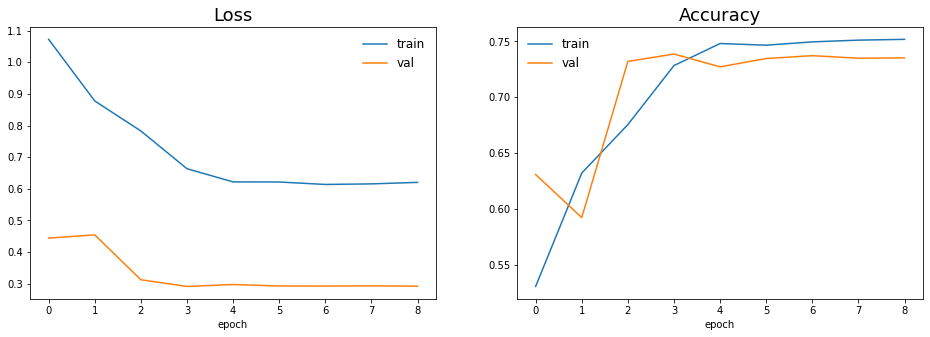

In [62]:
pa.plot_model_history(fitted_model)

**Without thresholds**

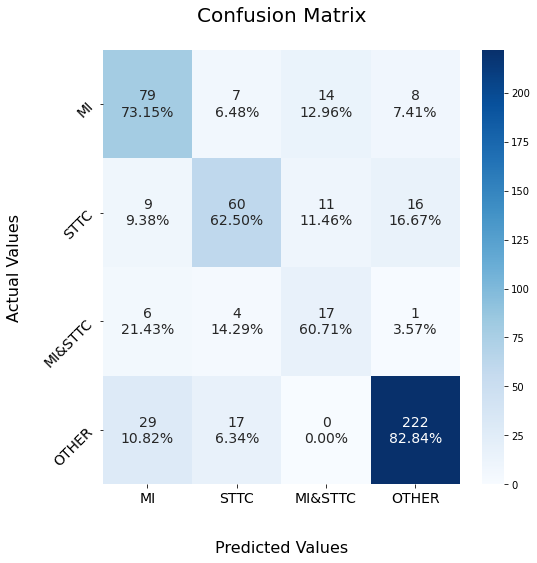

In [63]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

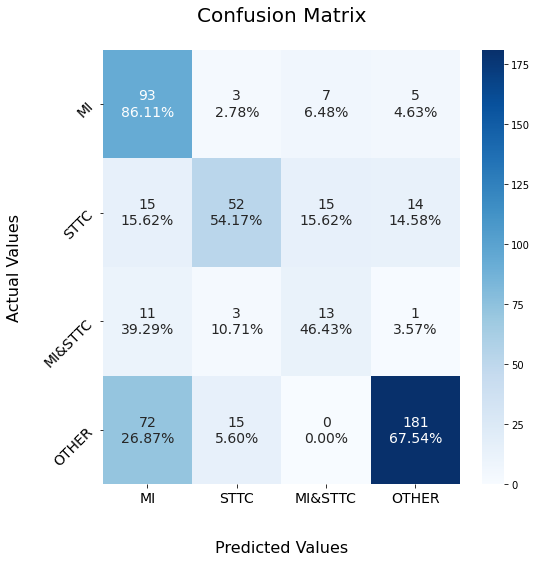

In [64]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multi-label

# =============================================================

In [261]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]

optimizer = 'adam'

In [137]:
CNN = Sequential([
    InputLayer(input_shape=(img_h, img_w)),
    
    Conv1D(128, 14, activation='relu', strides=3, padding="same"),
    MaxPool1D(),
    BatchNormalization(),

    Conv1D(256, 14, activation='relu', strides=3, padding="same"),
    MaxPool1D(),
    BatchNormalization(),

    Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.01)),
    MaxPool1D(),
    BatchNormalization(),

    #Conv1D(64, 3, activation='relu'),
    #MaxPool2D(),

    Flatten(),
    Dense(d_model, activation='relu'),
    Dense(4, activation='softmax')
])

CNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 500, 128)          21632     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 250, 128)         512       
 hNormalization)                                                 
                                                                 
 conv1d_10 (Conv1D)          (None, 84, 256)           459008    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 42, 256)          0         
 g1D)                                                            
                                                      

In [138]:
# Compile: Define training parameters
CNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
epochs = 50
batches = n_total_train//batch_size

### Following line overflows memory
fitted_model = CNN.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                       epochs=epochs, validation_data=(val_set_x, val_set_y),
                       callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/50
218/218 [==============================] - 7s 28ms/step - loss: 3.0669 - accuracy: 0.5601 - val_loss: 1.3019 - val_accuracy: 0.5756
Epoch 2/50
218/218 [==============================] - 6s 26ms/step - loss: 0.9750 - accuracy: 0.6380 - val_loss: 0.9421 - val_accuracy: 0.6571
Epoch 3/50
218/218 [==============================] - 6s 26ms/step - loss: 0.8521 - accuracy: 0.6915 - val_loss: 0.8371 - val_accuracy: 0.6998
Epoch 4/50
218/218 [==============================] - 6s 27ms/step - loss: 0.8038 - accuracy: 0.7141 - val_loss: 0.8647 - val_accuracy: 0.6703
Epoch 5/50
218/218 [==============================] - 6s 29ms/step - loss: 0.7594 - accuracy: 0.7228 - val_loss: 0.7796 - val_accuracy: 0.7075
Epoch 6/50
218/218 [==============================] - 7s 33ms/step - loss: 0.7351 - accuracy: 0.7384 - val_loss: 0.7474 - val_accuracy: 0.7272
Epoch 7/50
218/218 [==============================] - 7s 34ms/step - loss: 0.7237 - accuracy: 0.7409 - val_loss: 0.7451 - val_accuracy: 0.7281

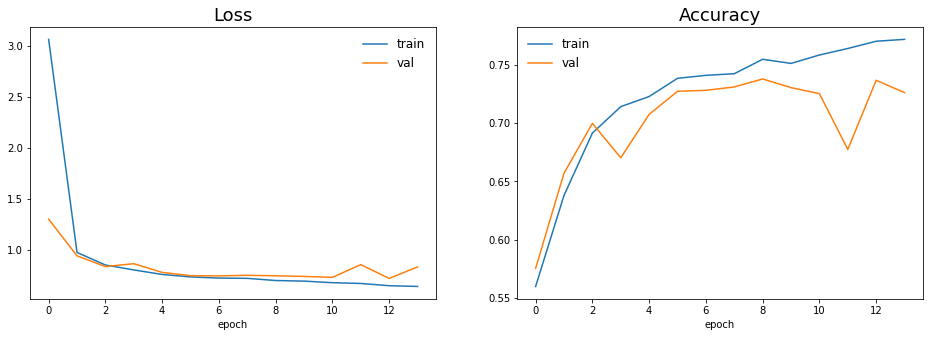

In [139]:
pa.plot_model_history(fitted_model)

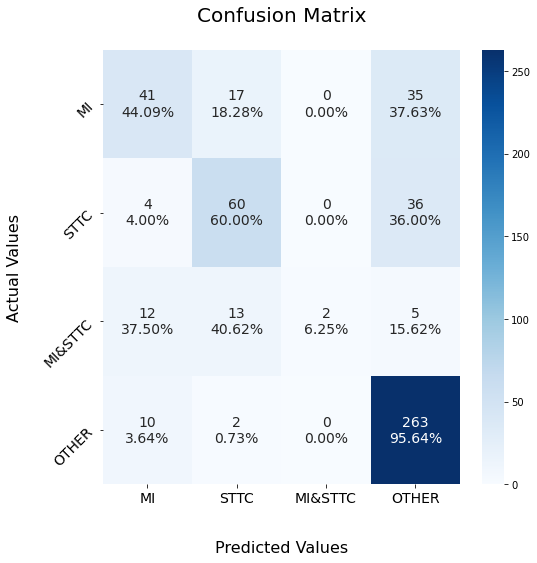

In [140]:
pa.plot_confusion_matrix(CNN, train_set_x, train_set_y, strat_df.columns[:-1], n_ex = n_ex, random_state = random_state)

# ----------------------------------------------------------------------------------------------------------

# =============================================================

## PTB-XL Superclasses (Train with 5 seconds, predict with 3)

# =============================================================

# ----------------------------------------------------------------------------------------------------------

### Loading Superclasses

Read the previously calculated DF:

In [193]:
superclasses_df = pd.read_csv('data/PTB-XL/Y_superclasses.csv', index_col=0)

We are mostly interested in the MI and STTC classes. For this reason, we OHE so that we have mutually exclusive columns for:

    i. MI (no STTC)
    ii. STTC (no MI)
    iii MI & STTC
    iv. Other

In [194]:
# Copy and keep only the classes of interest
strat_df = superclasses_df.copy()
strat_df = strat_df.reset_index()
strat_df.index = strat_df.index + 1
strat_df = strat_df[['MI', 'STTC']]

# Intersection between MI & STTC
strat_df['MI&STTC'] = (strat_df['MI'] == 1) & (strat_df['STTC'] == 1)
strat_df['MI&STTC'] = strat_df['MI&STTC'].astype(int)

# Correct MI and STTC columns given an intersection
strat_df['MI'] = strat_df['MI'] - strat_df['MI&STTC']
strat_df['STTC'] = strat_df['STTC'] - strat_df['MI&STTC']

# Create the OTHER column as the complement
strat_df['OTHER'] = (strat_df['MI'] == 0) & (strat_df['STTC'] == 0) & (strat_df['MI&STTC'] == 0)
strat_df['OTHER'] = strat_df['OTHER'].astype(int)

# Add a label column 
strat_df['label'] = strat_df.idxmax(axis=1)
print(strat_df.shape)
strat_df.head()

(21837, 5)


MI  STTC  MI&STTC  OTHER  label
1   0     0        0      1  OTHER
2   0     0        0      1  OTHER
3   0     0        0      1  OTHER
4   0     0        0      1  OTHER
5   0     0        0      1  OTHER

### Train, Validation & Test

We first reduce the length of the signals since it would be too computationally costly otherwise atm.

In [195]:
# Notice that this way to cut currently works only for PTB-XL, since all records are the of
# the same duration and frequency sampling

train_cut = 0.5
X_cut = X[:, :int(train_cut * X.shape[1]), :]

Define the proportions for each set.

In [196]:
val_size = 0.2
test_size = 0.2

Define the indices so that we can recover them later

In [197]:
indices = np.arange(len(X_cut))

Retrieve the train, validation and test sets for:

    x : The signals
    y : The labels
    idx : The indices of the original X and Y
    age_n_sex : The age and sex

In [198]:
# Train and test
train_set_x, test_set_x = train_test_split(X_cut, test_size=test_size, random_state=random_state)
train_set_y, test_set_y = train_test_split(strat_df.drop(['label'], 1), test_size=test_size, random_state=random_state)
train_set_idx, test_set_idx = train_test_split(indices, test_size=test_size, random_state=random_state)

# Train and val
train_set_x, val_set_x = train_test_split(train_set_x, test_size=val_size, random_state=random_state)
train_set_y, val_set_y = train_test_split(train_set_y, test_size=val_size, random_state=random_state)
train_set_idx, val_set_idx = train_test_split(train_set_idx, test_size=test_size, random_state=random_state)

# Get the age and sex given the indices
train_set_age_n_sex, mean_age = md.age_and_sex_set(Y, train_set_idx)
val_set_age_n_sex = md.age_and_sex_set(Y, val_set_idx, mean_age)
test_set_age_n_sex = md.age_and_sex_set(Y, test_set_idx, mean_age)

n_total_train = train_set_x.shape[0]
batches = n_total_train//batch_size

train_set_y = np.array(train_set_y)
val_set_y = np.array(val_set_y)
test_set_y = np.array(test_set_y)

Verify if the total amount of values for each set is adequate

In [199]:
print(train_set_y.shape)
print(val_set_y.shape)
print(test_set_y.shape)

(13975, 4)
(3494, 4)
(4368, 4)


### Add zeros in the first and last seconds of validation and test sets

In [200]:
val_test_cut = 0.3 / cut 
val_set_x = md.pad_zeros_before_n_after(val_set_x, val_test_cut)
test_set_x = md.pad_zeros_before_n_after(test_set_x, val_test_cut)

Verify the dimensions are the same.

In [201]:
print(train_set_y.shape)
print(val_set_y.shape)
print(test_set_y.shape)

(13975, 4)
(3494, 4)
(4368, 4)


Verify the age and sex were correctly processed. 

### Note: At the moment, we are only using PTB-XL. When we use the other datasets, there is no guarantee that the preprocessing for age and sex will be the same.

In [147]:
Y.iloc[train_set_idx][['age', 'sex']].head()

age     sex
5000   69    Male
16835  67  Female
12356  49  Female
3450   24    Male
10222  63    Male

In [148]:
train_set_age_n_sex[:5]

array([[69,  1],
       [67,  0],
       [49,  0],
       [24,  1],
       [63,  1]], dtype=int64)

We verify that we have a stratified distribution of labels inthe 3 sets.

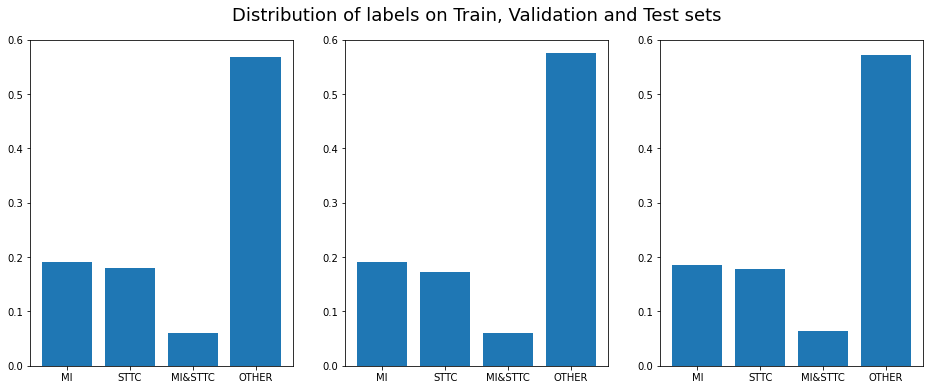

In [151]:
fig, axs = plt.subplots(1,3, figsize = (16,6))
axs[0].bar(strat_df.columns[:-1], train_set_y.sum(0) /  train_set_y.sum(), )
axs[1].bar(strat_df.columns[:-1], val_set_y.sum(0) /  val_set_y.sum())
axs[2].bar(strat_df.columns[:-1], test_set_y.sum(0) /  test_set_y.sum())
[ax.set_ylim(0,0.6) for ax in axs]

axs[1].set_title('Distribution of labels on Train, Validation and Test sets', y = 1.04, fontsize=18);

# =============================================================

### CNN Implementation

# =============================================================

#### Multibinary - Simplest model

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [152]:
model_id = 'PTB-XL_labels/own/5-3/multibinary_1.h5'

Parameters

In [153]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [154]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(64, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Conv1D(128, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Conv1D(256, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Flatten(),
            Dense(128, activation='relu'),
            Dense(4, activation='sigmoid')
])

Summary.

In [155]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2500, 64)          2368      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1250, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1250, 128)         24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 625, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 625, 256)          98560     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 312, 256)         0

In [156]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit(train_set_x, train_set_y, steps_per_epoch=batches,
                               epochs=epochs, validation_data=(val_set_x, val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/50
218/218 [==============================] - 21s 46ms/step - loss: 0.4497 - accuracy: 0.6090 - val_loss: 0.3786 - val_accuracy: 0.6468
Epoch 2/50
218/218 [==============================] - 8s 38ms/step - loss: 0.3297 - accuracy: 0.7047 - val_loss: 0.3562 - val_accuracy: 0.6726
Epoch 3/50
218/218 [==============================] - 10s 44ms/step - loss: 0.2864 - accuracy: 0.7498 - val_loss: 0.3773 - val_accuracy: 0.6425
Epoch 4/50
218/218 [==============================] - 10s 47ms/step - loss: 0.2452 - accuracy: 0.7898 - val_loss: 0.3974 - val_accuracy: 0.6471
Epoch 5/50
218/218 [==============================] - 10s 47ms/step - loss: 0.1858 - accuracy: 0.8516 - val_loss: 0.4500 - val_accuracy: 0.6417
Epoch 6/50
218/218 [==============================] - 10s 47ms/step - loss: 0.1217 - accuracy: 0.9153 - val_loss: 0.7017 - val_accuracy: 0.5655
Epoch 7/50
218/218 [==============================] - 10s 47ms/step - loss: 0.0742 - accuracy: 0.9601 - val_loss: 0.7634 - val_accuracy: 

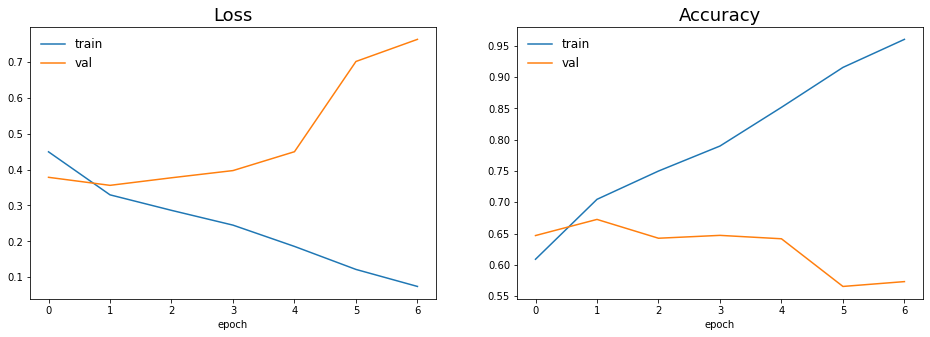

In [157]:
pa.plot_model_history(fitted_model)

**Without thresholds**

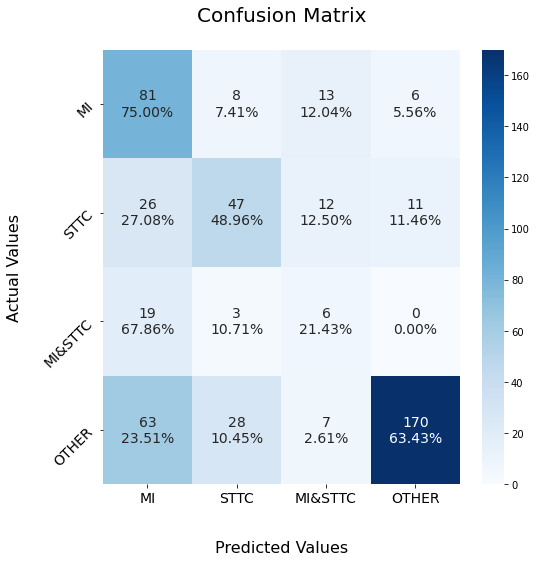

In [158]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

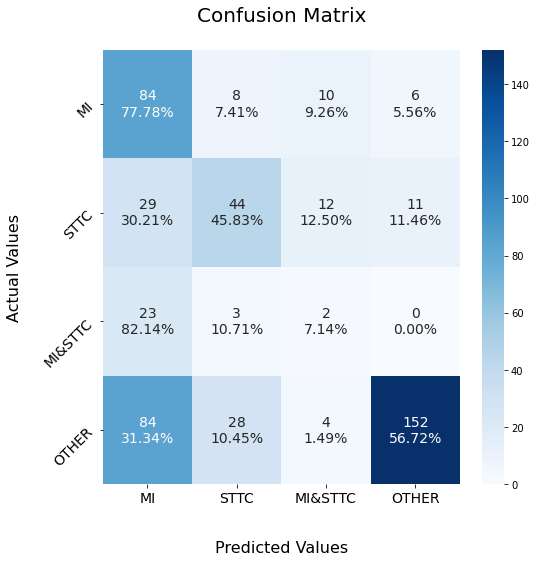

In [159]:
pa.plot_confusion_matrix(model, test_set_x, test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# =============================================================

#### Multibinary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Dropout + Age + Sex

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [202]:
model_id = 'PTB-XL_labels/own/5-3/multibinary_bn_l1_dr_as_1.h5'

Parameters

In [203]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [204]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    
    ### Convolutional Model
    conv_input = Input(shape=(img_h, img_w))

    x = Conv1D(128, 14, activation='relu', strides=3, padding="same")(conv_input)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(256, 14, activation='relu', strides=3, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006))(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Model(inputs = conv_input, outputs = x)
    
    
    ### Age and Sex Model
    wide_input = Input(shape=(2,))    
    y = Dense(10, activation='relu')(wide_input)    
    y = Model(inputs = wide_input, outputs = y)
    
    
    ### Combined Model
    combined = concatenate([x.output, y.output])
    z = Dense(d_model, activation='relu')(combined)
    z = Dense(4, activation='sigmoid')(z)

    model = Model(inputs=[x.input, y.input], outputs=z)

Summary.

In [205]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2500, 12)]   0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 834, 128)     21632       ['input_4[0][0]']                
                                                                                                  
 max_pooling1d_7 (MaxPooling1D)  (None, 417, 128)    0           ['conv1d_7[0][0]']               
                                                                                                  
 dropout_4 (Dropout)            (None, 417, 128)     0           ['max_pooling1d_7[0][0]']        
                                                                                            

In [206]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit((train_set_x, train_set_age_n_sex), train_set_y, steps_per_epoch=batches,
                               epochs=100, validation_data=((val_set_x, val_set_age_n_sex), val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=15)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/100
218/218 [==============================] - 20s 77ms/step - loss: 0.8944 - accuracy: 0.5467 - val_loss: 0.5638 - val_accuracy: 0.5753
Epoch 2/100
218/218 [==============================] - 16s 74ms/step - loss: 0.4581 - accuracy: 0.5630 - val_loss: 0.4548 - val_accuracy: 0.5750
Epoch 3/100
218/218 [==============================] - 15s 71ms/step - loss: 0.4446 - accuracy: 0.5758 - val_loss: 0.4152 - val_accuracy: 0.5873
Epoch 4/100
218/218 [==============================] - 16s 72ms/step - loss: 0.4139 - accuracy: 0.6115 - val_loss: 0.3973 - val_accuracy: 0.6239
Epoch 5/100
218/218 [==============================] - 16s 71ms/step - loss: 0.3956 - accuracy: 0.6345 - val_loss: 0.3919 - val_accuracy: 0.6388
Epoch 6/100
218/218 [==============================] - 16s 72ms/step - loss: 0.3882 - accuracy: 0.6424 - val_loss: 0.4780 - val_accuracy: 0.4946
Epoch 7/100
218/218 [==============================] - 16s 73ms/step - loss: 0.3758 - accuracy: 0.6658 - val_loss: 0.4000 - val_ac

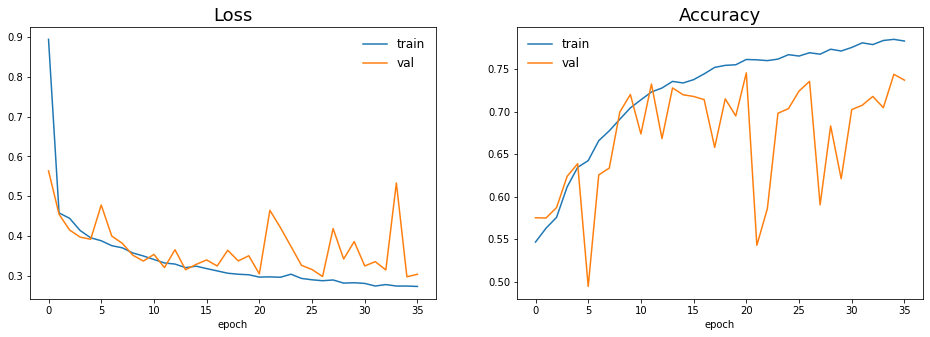

In [207]:
pa.plot_model_history(fitted_model)

**Without thresholds**

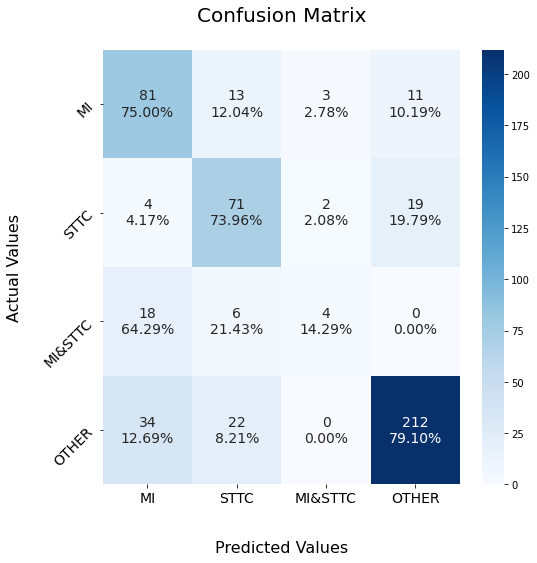

In [210]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

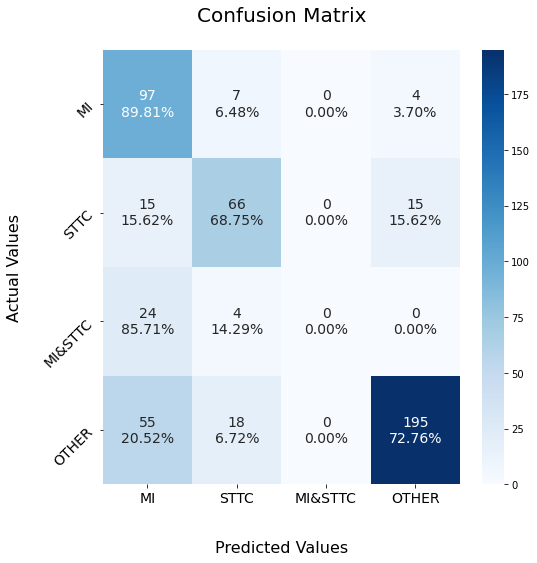

In [211]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

# ----------------------------------------------------------------------------------------------------------

# =============================================================

## PTB-XL Superclasses (MI vs OTHER)

# =============================================================

# ----------------------------------------------------------------------------------------------------------

### Loading Superclasses

Read the previously calculated DF:

In [157]:
superclasses_df = pd.read_csv('data/PTB-XL/Y_superclasses.csv', index_col=0)

We are mostly interested in the MI and STTC classes. For this reason, we OHE so that we have mutually exclusive columns for:

    i. MI (no STTC)
    ii. STTC (no MI)
    iii MI & STTC
    iv. Other

In [158]:
# Copy and keep only the classes of interest
strat_df = superclasses_df.copy()
strat_df = strat_df.reset_index()
strat_df.index = strat_df.index + 1
strat_df = strat_df[['MI']]


# Create the OTHER column as the complement
strat_df['OTHER'] = strat_df['MI'] == 0
strat_df['OTHER'] = strat_df['OTHER'].astype(int)

# Add a label column 
strat_df['label'] = strat_df.idxmax(axis=1)
print(strat_df.shape)
strat_df.head()

(21837, 3)


MI  OTHER  label
1   0      1  OTHER
2   0      1  OTHER
3   0      1  OTHER
4   0      1  OTHER
5   0      1  OTHER

### Train, Validation & Test

We first reduce the length of the signals since it would be too computationally costly otherwise atm.

In [159]:
# Notice that this way to cut currently works only for PTB-XL, since all records are the of
# the same duration and frequency sampling

train_cut = 0.5
X_cut = X[:, :int(train_cut * X.shape[1]), :]

Define the proportions for each set.

In [160]:
val_size = 0.2
test_size = 0.2

Define the indices so that we can recover them later

In [161]:
indices = np.arange(len(X_cut))

Retrieve the train, validation and test sets for:

    x : The signals
    y : The labels
    idx : The indices of the original X and Y
    age_n_sex : The age and sex

In [162]:
# Train and test
train_set_x, test_set_x = train_test_split(X_cut, test_size=test_size, random_state=random_state)
train_set_y, test_set_y = train_test_split(strat_df.drop(['label'], 1), test_size=test_size, random_state=random_state)
train_set_idx, test_set_idx = train_test_split(indices, test_size=test_size, random_state=random_state)

# Train and val
train_set_x, val_set_x = train_test_split(train_set_x, test_size=val_size, random_state=random_state)
train_set_y, val_set_y = train_test_split(train_set_y, test_size=val_size, random_state=random_state)
train_set_idx, val_set_idx = train_test_split(train_set_idx, test_size=test_size, random_state=random_state)

# Get the age and sex given the indices
train_set_age_n_sex, mean_age = md.age_and_sex_set(Y, train_set_idx)
val_set_age_n_sex = md.age_and_sex_set(Y, val_set_idx, mean_age)
test_set_age_n_sex = md.age_and_sex_set(Y, test_set_idx, mean_age)

n_total_train = train_set_x.shape[0]
batches = n_total_train//batch_size

train_set_y = np.array(train_set_y)
val_set_y = np.array(val_set_y)
test_set_y = np.array(test_set_y)

Verify if the total amount of values for each set is adequate

In [30]:
print(train_set_y.shape)
print(val_set_y.shape)
print(test_set_y.shape)

(13975, 2)
(3494, 2)
(4368, 2)


Verify the age and sex were correctly processed. 

### Note: At the moment, we are only using PTB-XL. When we use the other datasets, there is no guarantee that the preprocessing for age and sex will be the same.

In [31]:
Y.iloc[train_set_idx][['age', 'sex']].head()

age     sex
5000   69    Male
16835  67  Female
12356  49  Female
3450   24    Male
10222  63    Male

In [32]:
train_set_age_n_sex[:5]

array([[69,  1],
       [67,  0],
       [49,  0],
       [24,  1],
       [63,  1]], dtype=int64)

We verify that we have a stratified distribution of labels inthe 3 sets.

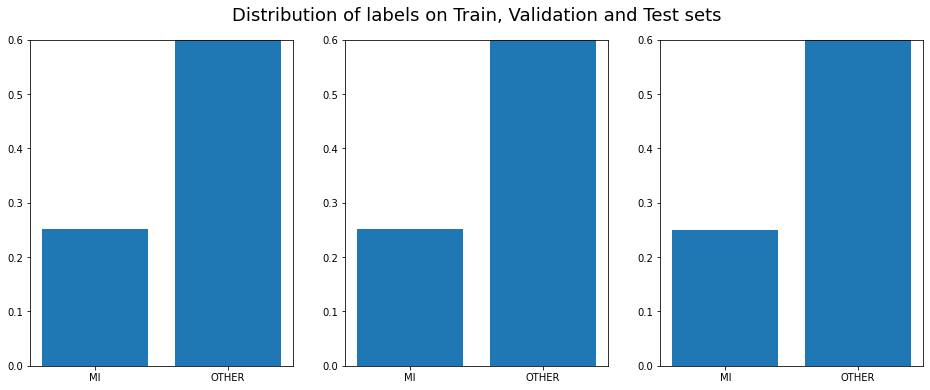

In [33]:
fig, axs = plt.subplots(1,3, figsize = (16,6))
axs[0].bar(strat_df.columns[:-1], train_set_y.sum(0) /  train_set_y.sum(), )
axs[1].bar(strat_df.columns[:-1], val_set_y.sum(0) /  val_set_y.sum())
axs[2].bar(strat_df.columns[:-1], test_set_y.sum(0) /  test_set_y.sum())
[ax.set_ylim(0,0.6) for ax in axs]

axs[1].set_title('Distribution of labels on Train, Validation and Test sets', y = 1.04, fontsize=18);

# =============================================================

### CNN Implementation

# =============================================================

#### Binary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Dropout + Age + Sex

# =============================================================

Define the model id. This must be different from any other since we are not overwritting.

In [ ]:
model_id = 'PTB-XL_labels/mi_other/binary_bn_l1_dr_as_1.h5'

Parameters

In [35]:
batch_size = 64
img_h = X_cut.shape[1]
img_w = X_cut.shape[2]
d_model = 256
optimizer = 'adam'

Load the model if it has been created, else create a new instance of it.

In [36]:
found = False

for path, currentDirectory, files in os.walk("models"):
    for file in files:
        if 'models/' + model_id == os.path.join(path, file).replace("\\", "/"):  
            
            model = tf.keras.models.load_model('models/' + model_id)
            fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)
            
            found = True

if not found:
    pa.make_dir('./models/' + '/'.join(model_id.split('/')[:-1]))
    
    ### Convolutional Model
    conv_input = Input(shape=(img_h, img_w))

    x = Conv1D(128, 14, activation='relu', strides=3, padding="same")(conv_input)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(256, 14, activation='relu', strides=3, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006))(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Model(inputs = conv_input, outputs = x)
    
    
    ### Age and Sex Model
    wide_input = Input(shape=(2,))    
    y = Dense(10, activation='relu')(wide_input)    
    y = Model(inputs = wide_input, outputs = y)
    
    
    ### Combined Model
    combined = concatenate([x.output, y.output])
    z = Dense(d_model, activation='relu')(combined)
    z = Dense(2, activation='sigmoid')(z)

    model = Model(inputs=[x.input, y.input], outputs=z)

Summary.

In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2500, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 834, 128)     21632       ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 417, 128)     0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 417, 128)     0           ['max_pooling1d[0][0]']          
                                                                                            

In [38]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    fitted_model = model.fit((train_set_x, train_set_age_n_sex), train_set_y, steps_per_epoch=batches,
                               epochs=100, validation_data=((val_set_x, val_set_age_n_sex), val_set_y),                                 
                               callbacks=[EarlyStopping(monitor='val_accuracy', patience=10)])
    
    # Save
    model.save('models/' + model_id)
    
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv('models/' + model_id[:-2] + 'csv')

Epoch 1/100
218/218 [==============================] - 25s 71ms/step - loss: 1.1894 - accuracy: 0.7313 - val_loss: 0.6614 - val_accuracy: 0.7461
Epoch 2/100
218/218 [==============================] - 15s 68ms/step - loss: 0.5165 - accuracy: 0.7823 - val_loss: 0.4506 - val_accuracy: 0.8062
Epoch 3/100
218/218 [==============================] - 15s 68ms/step - loss: 0.4609 - accuracy: 0.8109 - val_loss: 0.4564 - val_accuracy: 0.8108
Epoch 4/100
218/218 [==============================] - 15s 69ms/step - loss: 0.4387 - accuracy: 0.8205 - val_loss: 0.4658 - val_accuracy: 0.7899
Epoch 5/100
218/218 [==============================] - 16s 74ms/step - loss: 0.4212 - accuracy: 0.8281 - val_loss: 0.4395 - val_accuracy: 0.8134
Epoch 6/100
218/218 [==============================] - 17s 77ms/step - loss: 0.4134 - accuracy: 0.8325 - val_loss: 0.4135 - val_accuracy: 0.8354
Epoch 7/100
218/218 [==============================] - 17s 76ms/step - loss: 0.3844 - accuracy: 0.8485 - val_loss: 0.4430 - val_ac

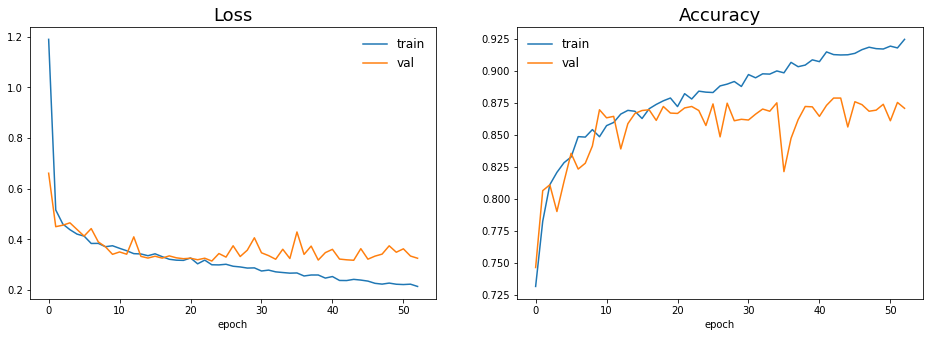

In [39]:
pa.plot_model_history(fitted_model)

**Without thresholds**

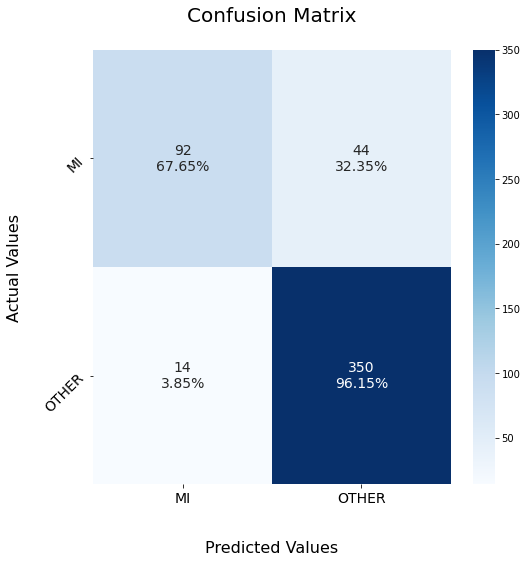

In [40]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

**With thresholds**

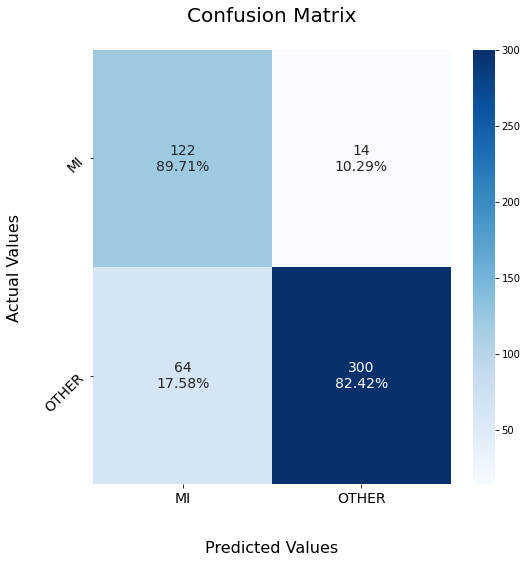

In [45]:
pa.plot_confusion_matrix_mi(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, 
                         thresholds = {'PTB-XL': 
                                       {'MI': {'idx': 0, 'threshold': 0.1},
                                        'MI&STTC': {'idx': 2, 'threshold': 0.3}}})

# September 16 presentation

## MI, STTC, MI&STTC, OTHER

In [96]:
model_id = 'PTB-XL_labels/own/multibinary_bn_l1_dr_as_2.h5'
model = tf.keras.models.load_model('models/' + model_id)
fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)

In [144]:
cm = pa.plot_confusion_matrix(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], 
                         n_ex = len(test_set_y) // 10,
                         random_state = random_state, return_cm=True)

sens = np.diag(cm) / cm.sum(1)
spec = np.zeros_like(sens)
for k in range(len(spec)):
    TN = np.delete(np.delete(cm, k, 1), k, 0)
    FP = np.delete(cm[:, k], k, 0)
    spec[k] = TN.sum() / (TN.sum() + FP.sum())
    
print("Sensitivities", 100 * sens)
print("Weighted Sensitivity", 100 * sens @ w.T)
print("Specificities", 100 * spec)
print("Weighted Specificity", 100 * spec @ w.T)
print("Accuracy", 100 * np.diag(cm).sum() / cm.sum())

Sensitivities [70.96774194 62.5         8.33333333 91.77489177]
Weighted Sensitivity 76.8348623853211
Specificities [91.25364431 94.25287356 99.51456311 76.09756098]
Weighted Specificity 84.28377957517196
Accuracy 76.8348623853211


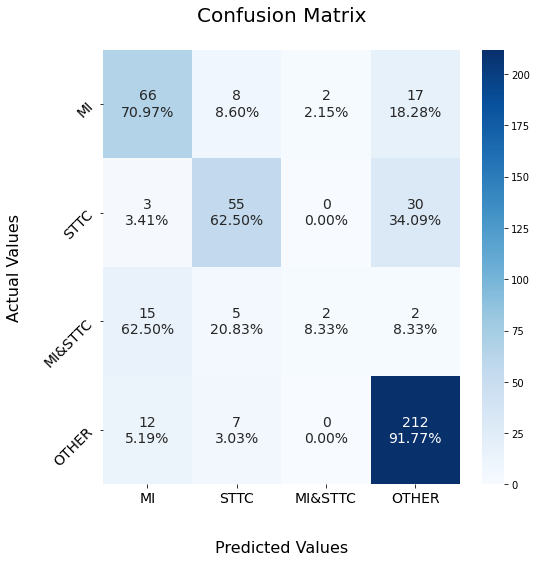

In [150]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], 
                         n_ex = len(test_set_y) // 10,
                         random_state = random_state, return_cm=False)

In [156]:
cm = pa.plot_confusion_matrix(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], 
                         n_ex = len(test_set_y) // 10,
                         random_state = random_state, return_cm=True,
                         thresholds = {'PTB-XL': 
                                       {'MI': {'idx': 0, 'threshold': 0.2},
                                        'MI&STTC': {'idx': 2, 'threshold': 0.3}}})

sens = np.diag(cm) / cm.sum(1)
spec = np.zeros_like(sens)
for k in range(len(spec)):
    TN = np.delete(np.delete(cm, k, 1), k, 0)
    FP = np.delete(cm[:, k], k, 0)
    spec[k] = TN.sum() / (TN.sum() + FP.sum())
    
print("Sensitivities", 100 * sens)
print("Weighted Sensitivity", 100 * sens @ w.T)
print("Specificities", 100 * spec)
print("Weighted Specificity", 100 * spec @ w.T)
print("Accuracy", 100 * np.diag(cm).sum() / cm.sum())

Sensitivities [78.49462366 59.09090909  0.         88.74458874]
Weighted Sensitivity 75.6880733944954
Specificities [ 86.88046647  94.25287356 100.          80.        ]
Weighted Specificity 85.4452666410262
Accuracy 75.68807339449542


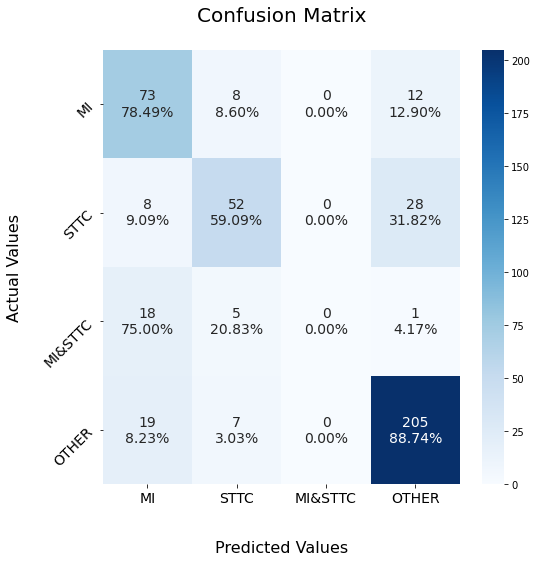

In [154]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], 
                         n_ex = len(test_set_y) // 10,
                         random_state = random_state, return_cm=False,
                         thresholds = {'PTB-XL': 
                                       {'MI': {'idx': 0, 'threshold': 0.2},
                                        'MI&STTC': {'idx': 2, 'threshold': 0.3}}})

## MI vs OTHER

In [165]:
model_id = 'PTB-XL_labels/mi_other/binary_bn_l1_dr_as_1.h5'
model = tf.keras.models.load_model('models/' + model_id)
fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)

In [166]:
cm = pa.plot_confusion_matrix_mi(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], 
                         n_ex = len(test_set_y) // 10,
                         random_state = random_state, return_cm=True)
sens = np.diag(cm) / cm.sum(1)
print("Sensitivity, Specificity", 100 * sens)
print("Accuracy", 100 * np.diag(cm).sum() / cm.sum())

Sensitivity, Specificity [67.52136752 95.61128527]
Accuracy 88.07339449541284


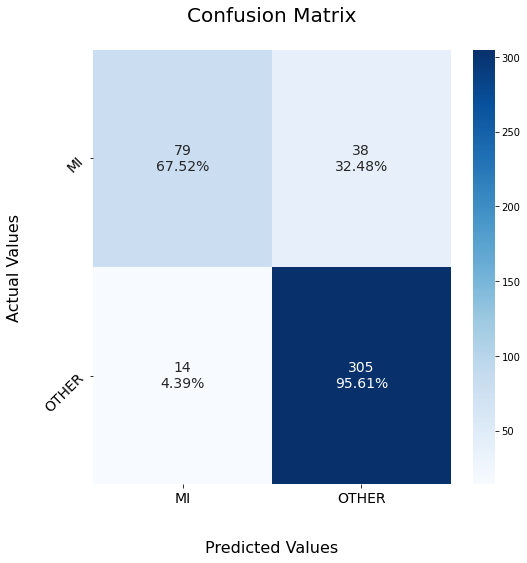

In [167]:
pa.plot_confusion_matrix_mi(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], 
                         n_ex = len(test_set_y) // 10,
                         random_state = random_state, return_cm=False)

In [168]:
cm = pa.plot_confusion_matrix_mi(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], 
                         n_ex = len(test_set_y) // 10,
                         random_state = random_state, return_cm=True,
                         thresholds = {'PTB-XL': 
                                       {'MI': {'idx': 0, 'threshold': 0.2},
                                        'MI&STTC': {'idx': 2, 'threshold': 0.3}}})

sens = np.diag(cm) / cm.sum(1)
print("Sensitivity, Specificity", 100 * sens)
print("Accuracy", 100 * np.diag(cm).sum() / cm.sum())

Sensitivity, Specificity [82.05128205 89.65517241]
Accuracy 87.61467889908256


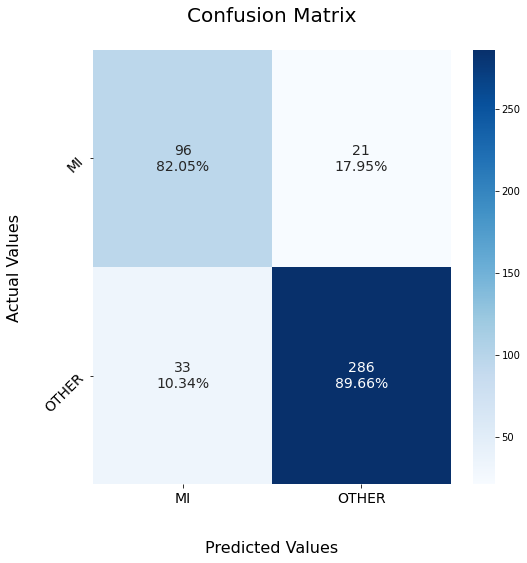

In [169]:
pa.plot_confusion_matrix_mi(model, (test_set_x, test_set_age_n_sex), test_set_y, strat_df.columns[:-1], 
                         n_ex = len(test_set_y) // 10,
                         random_state = random_state, return_cm=False,
                         thresholds = {'PTB-XL': 
                                       {'MI': {'idx': 0, 'threshold': 0.2},
                                        'MI&STTC': {'idx': 2, 'threshold': 0.3}}})

# Analysis of Erroneous Predictions

In [236]:
model_id = 'PTB-XL_labels/fir_m1_p1/multibinary_bn_l1_dr_sp_1.h5'
# model_id = 'PTB-XL_labels/own/multibinary_bn_l1_dr_as_2.h5'
model = tf.keras.models.load_model('models/' + model_id)
fitted_model = pd.read_csv('models/' + model_id[:-2] + 'csv', index_col=0)

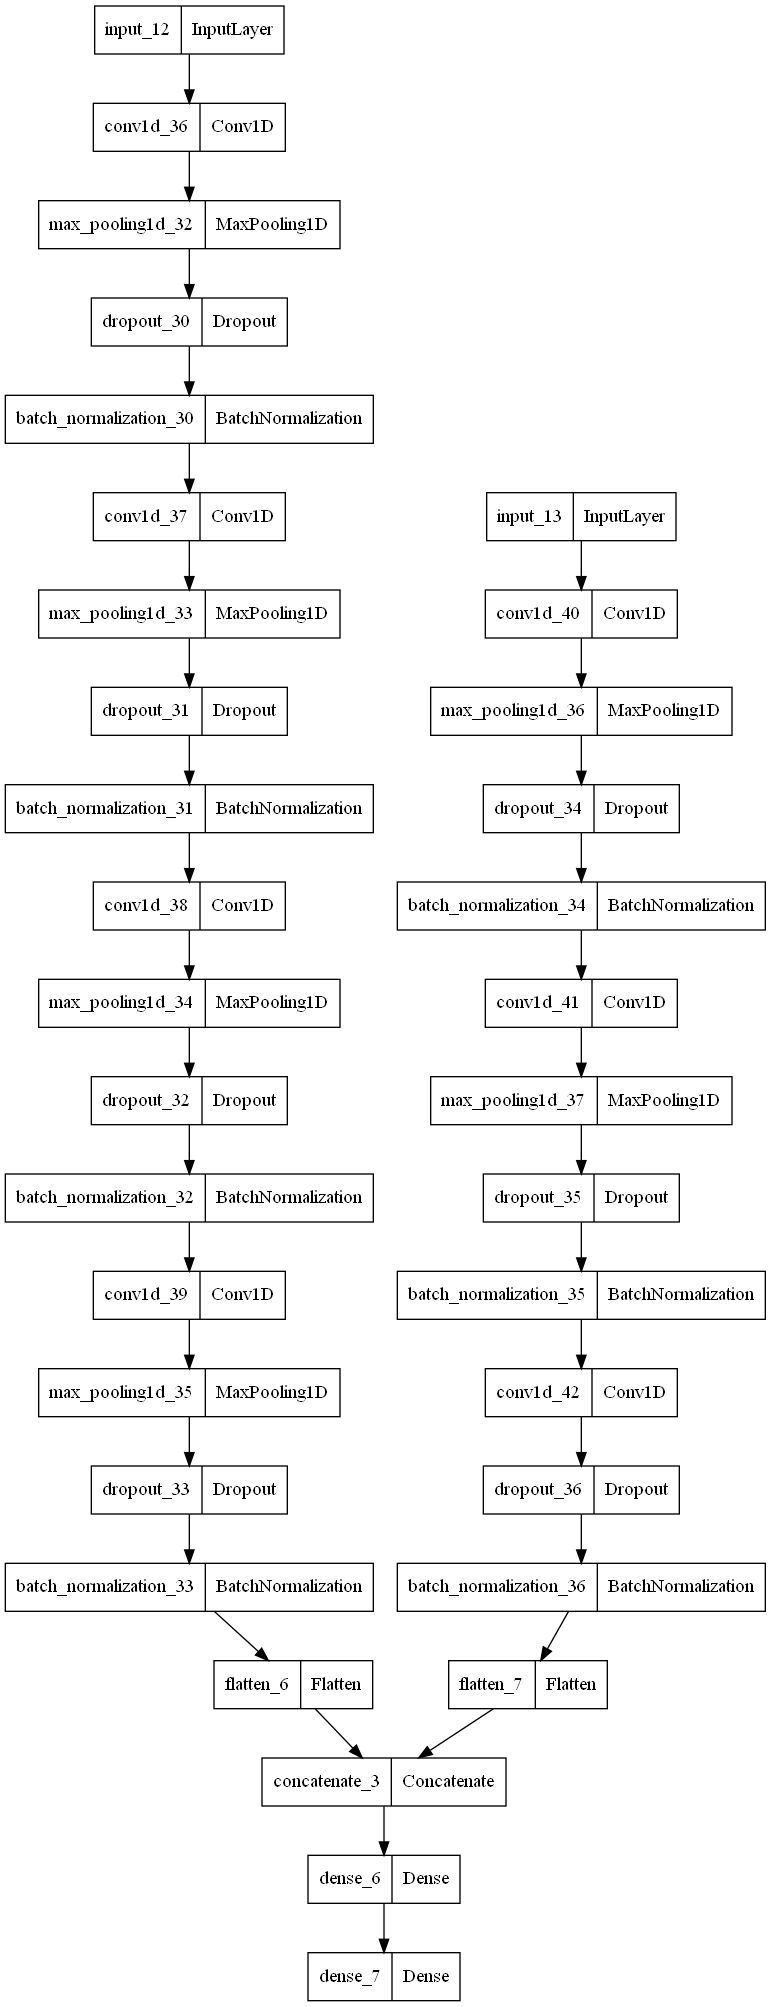

In [237]:
plot_model(model)

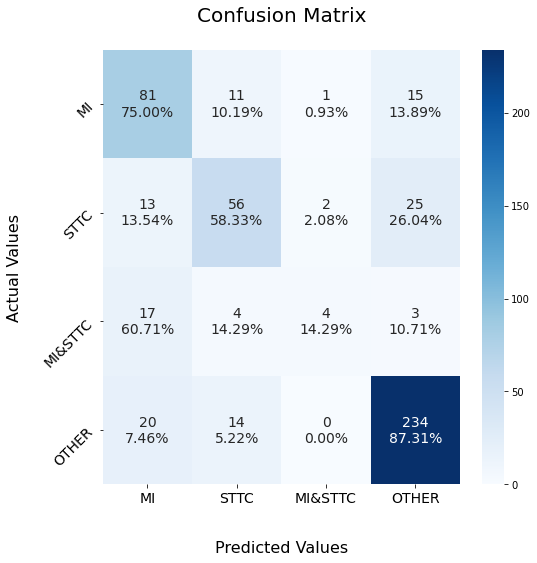

In [239]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_la), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state)

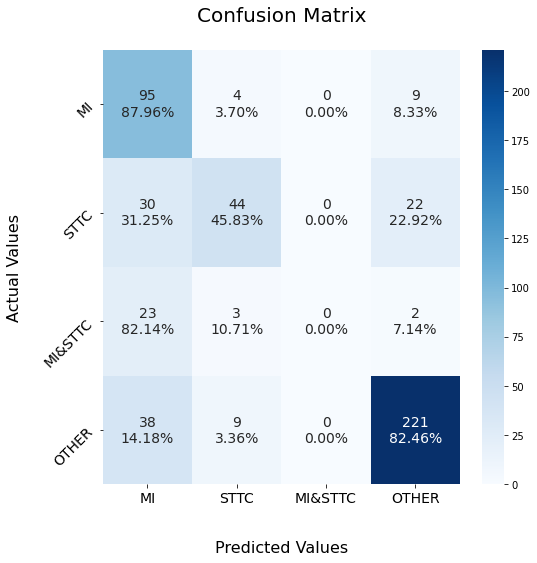

In [240]:
pa.plot_confusion_matrix(model, (test_set_x, test_set_la), test_set_y, strat_df.columns[:-1], n_ex = n_ex, 
                         random_state = random_state, thresholds = thresholds)

In [263]:
j = 98 # 304, 
k = test_set_idx[j]
y = test_set_x[j]
y = y.reshape(1, y.shape[0], y.shape[1])
# a_s = train_set_age_n_sex[j]
# a_s = a_s.reshape(1, a_s.shape[0])
la = train_set_la[j]
la = la.reshape(1, la.shape[0], la.shape[1])
y_true = test_set_y[j]
x = np.arange(0, y.shape[1], 1)/500

# print(model.predict((y,a_s)))
print(model.predict((y,la)))
print(y_true)

[[0.6891252  0.07702293 0.12796006 0.12158283]]
[0 0 1 0]


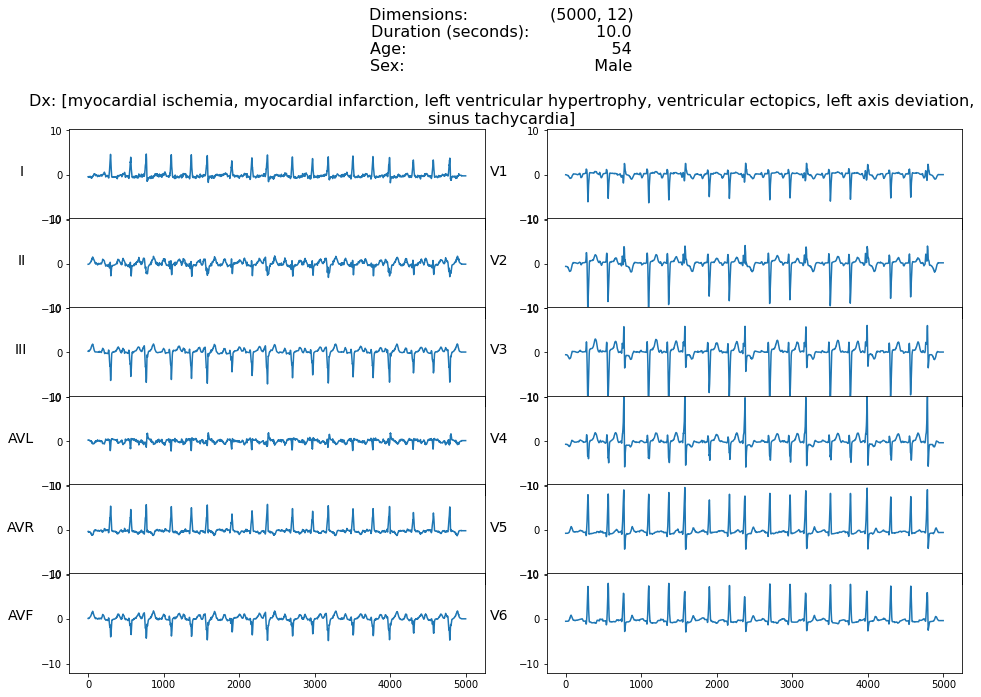

In [265]:
path = f'data/{current_db}/'
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
pa.plot_ecg(example[0], metadata=metadata, ylim=(example[0].min(), example[0].max()))

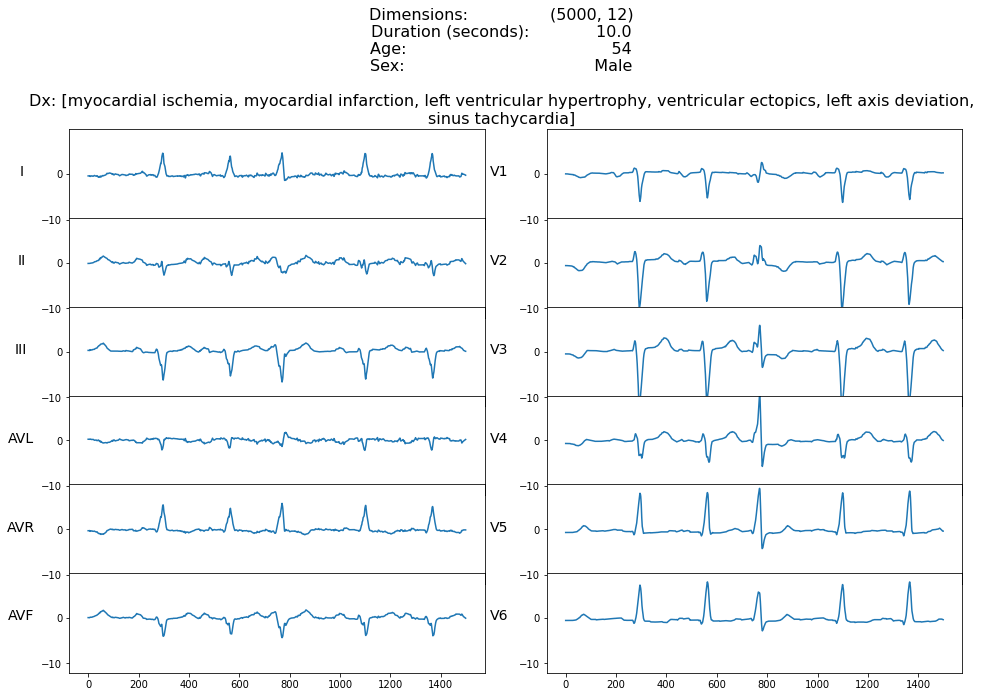

In [264]:
path = f'data/{current_db}/'
example = wfdb.rdsamp(path+hea_files[k])
metadata = {"info": example, "labels": labels, "path": None}
pa.plot_ecg(y[0], metadata=metadata, ylim=(y[0].min(), y[0].max()))

# Best Models

We look for each model, retrieve its validation accuracy history, and calculate the mean of the last n values. This will be one metric to select the best models.

In [94]:
# Amount of values at the end to compute the mean
n_to_calculate_mean = 6

# Initialize to store the validation accuracies
mean_final_val_accuracies = {}

# For each file, retrieve the validation accuracy and store it
for path, currentDirectory, files in os.walk("models"):
    for file in files:        
        if 'csv' in file:
            
            fitted_model = pd.read_csv(os.path.join(path, file), index_col=0)
            mean_final_val_accuracies[path.split('\\')[-1] + '/' + file[:-4]] \
                    = fitted_model['val_accuracy'].tail(n_to_calculate_mean).mean()

# Convert to pd.DataFrame for easier usage
mean_final_val_accuracies = pd.DataFrame({key : [value] for key, value in mean_final_val_accuracies.items()})

# Sort
sorted_models = mean_final_val_accuracies.iloc[0].sort_values(ascending=False)
sorted_models

mi_other/binary_bn_l1_dr_as_1          0.869681
own/multibinary_bn_l1_dr_as_2          0.766027
own/multibinary_bn_l1_dr_3             0.763690
own/multibinary_bn_l1_dr_2             0.760876
own/multibinary_bn_l1_dr_9             0.760780
antonior92/multibinary_original        0.759445
own/multibinary_bn_l1_dr_5             0.758729
own/multibinary_bn_l1_dr_7             0.758443
own/multibinary_bn_l1_dr_8             0.758157
own/multibinary_bn_l1_dr_as_3          0.755676
own/multibinary_bn_l1_dr_1             0.753673
own/multibinary_bn_l1_dr_6             0.750048
fir_m1_p1/multibinary_bn_l1_dr_sp_1    0.749666
own/multibinary_bn_l1_5                0.743274
fir_m1_p1/multibinary_bn_l1_dr_as_3    0.742129
own/multibinary_bn_l1_2                0.741843
own/multibinary_bn_3                   0.741748
own/multibinary_bn_l1_dr_4             0.741462
own/multibinary_bn_l1_dr_as_1          0.741080
own/multibinary_bn_2                   0.740269
antonior92/multibinary_cw_lr           0